In [ ]:
#mount shared google dir containing datasets and output embeddings
from google.colab import drive
drive.mount('/content/drive')
# %cd drive/My Drive/Colab Notebooks/openVaccine #indra drive location

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import time
from collections import defaultdict
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.model_selection import train_test_split
import csv 

import matplotlib.pyplot as plt


class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

av = Namespace( want_cuda                    = True,
                  has_cuda                   = torch.cuda.is_available(),
                  BATCH_SIZE                 = 128,
                  RANDOM_STATE               = 42,
                  DIR_PATH                   ="/content/drive/My Drive/Colab Notebooks/openVaccine/stanford-covid-vaccine")

av.DIR_PATH="/content/drive/MyDrive/openVaccine"              

In [ ]:
import csv
filename = "/content/drive/MyDrive/openVaccine/model_performance.csv"
# fields=['MODEL_NAME','LEARNING_RATE','TEST_LOSS','TEST_LOSS_1','TEST_LOSS_2','TEST_LOSS_3']
        
# # writing to csv file 

# with open(filename, 'w') as csvfile: 
#     csvwriter = csv.writer(csvfile)     
#     csvwriter.writerow(fields) 
#     csvfile.close() 

**Data Processing Functions**

In [ ]:
def gen_one_hot_features(df) :
  tokenSequence = {x:i for i, x in enumerate('ACGU')}
  tokenStructure = {x:i for i, x in enumerate('().')}
  tokenLoopType  = {x:i for i, x in enumerate('BEHIMSX')}
  identitySequence = np.identity(4)
  identityStructure = np.identity(3)
  identityLoopType = np.identity(7)

  a=np.array(df['sequence'].map(lambda seq: np.array([identitySequence[tokenSequence[x]] for x in seq])).tolist())
  b=np.array(df['structure'].map(lambda seq: np.array([identityStructure[tokenStructure[x]] for x in seq])).tolist())
  c=np.array(df['predicted_loop_type'].map(lambda seq: np.array([identityLoopType[tokenLoopType[x]] for x in seq])).tolist())   
  return  np.concatenate((a,b,c),axis=2)

def fetch_dataset(use_one_hot = True, use_filter = True): 
  train_fp = os.path.join(av.DIR_PATH, 'stanford-covid-vaccine/train.json')
  train_data=pd.read_json(train_fp,lines=True)
  if use_filter:
    train_data = train_data[train_data.SN_filter==1]

  train_feat_mat1 = np.load(av.DIR_PATH+"/all_train_feats_sn_filter_eq_1.npy")
  if use_one_hot:
    train_feat_mat2 = gen_one_hot_features(train_data)
    train_feat_mat = np.concatenate((train_feat_mat1,train_feat_mat2),axis=2)
  else:
    train_feat_mat = train_feat_mat1  
  train_feat_tensor = torch.tensor(train_feat_mat).float()

  pred_cols = ['reactivity', 'deg_Mg_pH10','deg_Mg_50C', 'deg_pH10', 'deg_50C']
  train_labels = np.array(train_data[pred_cols].values.tolist()).transpose(0,2,1)
  train_labels_tensor = torch.tensor(train_labels).float()
  print(train_feat_tensor.shape, train_labels.shape)
  return train_feat_tensor, train_labels_tensor

def fetch_data_splits(X,Y,tfrac=0.20,vfrac=0.1): 
  #TODO: dump splits to disk
  Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y, test_size=tfrac, random_state=av.RANDOM_STATE)
  Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain,Ytrain, test_size=vfrac, random_state=av.RANDOM_STATE)


  train_dataset = TensorDataset(Xtrain, Ytrain)
  val_dataset   = TensorDataset(Xval, Yval)
  test_dataset  = TensorDataset(Xtest, Ytest)

  train_loader = DataLoader(train_dataset, batch_size=av.BATCH_SIZE, shuffle=True, num_workers=8)
  val_loader   = DataLoader(val_dataset, batch_size=av.BATCH_SIZE, shuffle=True, num_workers=8)
  test_loader  = DataLoader(test_dataset, batch_size=av.BATCH_SIZE, shuffle=True, num_workers=8)

  tr_sz   = Xtrain.shape[0]
  test_sz = Xtest.shape[0]
  val_sz  = Xval.shape[0]

  return train_loader, val_loader, test_loader, tr_sz, test_sz, val_sz


**Model Class**

In [ ]:
class OpenVaccineLSTM(nn.Module):
  def __init__(self, av,seq_len=107,pred_len=68):
    super(OpenVaccineLSTM, self).__init__()
    self.av = av
    self.pred_len = pred_len
    self.lstm_input_size  = 121 #TODO: fetch no. from tensor shape instead of hardcoding
    self.lstm_hidden_size = self.av.LSTM_HIDDEN_DIM
    if av.lstm_bidir:
      self.lstm = nn.LSTM(self.lstm_input_size,self.lstm_hidden_size,num_layers=1,batch_first=True,bidirectional=True)
      self.pred_1_fc = nn.Linear(2*self.lstm_hidden_size,5)
    else:
      self.lstm = nn.LSTM(self.lstm_input_size,self.lstm_hidden_size,num_layers=1,batch_first=True,bidirectional=False)
      self.pred_1_fc = nn.Linear(self.lstm_hidden_size,5)

    
 
  def forward(self, features_tensor): 
    temp,_ = self.lstm(features_tensor)
    preds = self.pred_1_fc(temp)
      
    return preds

  def computeLoss(self,neighbour_features_tensor,labels_tensor):
    node_preds = self.forward(neighbour_features_tensor)
    loss = (torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,0][:,0:self.pred_len], labels_tensor[:,:,0])) +
                torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,1][:,0:self.pred_len], labels_tensor[:,:,1])) +
                torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,2][:,0:self.pred_len], labels_tensor[:,:,2]))) / 3
    return loss

  def computeLoss1(self,neighbour_features_tensor,labels_tensor):
    node_preds = self.forward(neighbour_features_tensor)
    loss1 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,0][:,0:self.pred_len], labels_tensor[:,:,0]))
    loss2 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,1][:,0:self.pred_len], labels_tensor[:,:,1]))
    loss3 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,2][:,0:self.pred_len], labels_tensor[:,:,2]))
    return loss1,loss2,loss3

class OpenVaccineCNN(nn.Module):
  def __init__(self, av,seq_len=107,pred_len=68):
    super(OpenVaccineCNN, self).__init__()
    self.av = av
    self.pred_len = pred_len

    self.cnn = nn.Conv1d(seq_len,pred_len,3,stride=1)
    self.pred_1_fc = nn.Linear(119,5)
 
  def forward(self, features_tensor): 
    temp = self.cnn(features_tensor)
    preds = self.pred_1_fc(temp)
      
    return preds

  def computeLoss(self,neighbour_features_tensor,labels_tensor):
    node_preds = self.forward(neighbour_features_tensor)
    loss = (torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,0][:,0:self.pred_len], labels_tensor[:,:,0])) +
                torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,1][:,0:self.pred_len], labels_tensor[:,:,1])) +
                torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,2][:,0:self.pred_len], labels_tensor[:,:,2]))) / 3
    return loss
  
  def computeLoss1(self,neighbour_features_tensor,labels_tensor):
    node_preds = self.forward(neighbour_features_tensor)
    loss1 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,0][:,0:self.pred_len], labels_tensor[:,:,0]))
    loss2 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,1][:,0:self.pred_len], labels_tensor[:,:,1]))
    loss3 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,2][:,0:self.pred_len], labels_tensor[:,:,2]))
    return loss1,loss2,loss3


class Feedforward(torch.nn.Module):
        def __init__(self, av ,seq_len=107,pred_len=68):
            super(Feedforward, self).__init__()
            self.av = av
            self.pred_len = pred_len
            self.input_size = 121
            self.hidden_size  = self.av.LSTM_HIDDEN_DIM
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 5)
            #self.sigmoid = torch.nn.Sigmoid()

        def forward(self, features_tensor):
            hidden = self.fc1(features_tensor)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            #output = self.sigmoid(output)

            return output

        def computeLoss(self, neighbour_features_tensor,labels_tensor):
            node_preds = self.forward(neighbour_features_tensor)
            loss = (torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,0][:,0:self.pred_len], labels_tensor[:,:,0])) +
                        torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,1][:,0:self.pred_len], labels_tensor[:,:,1])) +
                        torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,2][:,0:self.pred_len], labels_tensor[:,:,2]))) / 3
            return loss
        def computeLoss1(self, neighbour_features_tensor,labels_tensor):
            node_preds = self.forward(neighbour_features_tensor)
            loss1 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,0][:,0:self.pred_len], labels_tensor[:,:,0]))
            loss2 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,1][:,0:self.pred_len], labels_tensor[:,:,1]))
            loss3 = torch.sqrt(torch.nn.MSELoss()(node_preds[:,:,2][:,0:self.pred_len], labels_tensor[:,:,2]))
            return loss1,loss2,loss3


**Train-Eval-Run**

In [ ]:
def train_fn(epoch, model, train_loader,optimizer,sz):
    start = time.time() 
    model.train()
    model.zero_grad()  
    total_loss=0  
    for index, (feats, label) in enumerate(train_loader):
        feats = feats.cuda()
        label = label.cuda()        
        loss = model.computeLoss(feats,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = total_loss+ loss.item()
    #total_loss = total_loss/(index+1) 
    print("epoch: {} Train loss: {} time: {}".format(epoch, total_loss/sz, time.time()-start))
    return total_loss/sz


def eval_fn(epoch, model, loader, sz):
    start = time.time() 
    model.eval()   
    total_loss=0 
    for index, ( padded_feat, label) in enumerate(loader):
        padded_feat = padded_feat.cuda()
        label = label.cuda()
        loss = model.computeLoss(padded_feat,label)
        total_loss = total_loss+ loss.item()
    print("epoch: {} Eval loss: {} time: {}".format(epoch, total_loss/sz, time.time()-start))
    return total_loss/sz

def eval_fn1(epoch, model, loader, sz):
    start = time.time() 
    model.eval()   
    total_loss1=0 
    total_loss2=0 
    total_loss3=0 
    for index, ( padded_feat, label) in enumerate(loader):
        padded_feat = padded_feat.cuda()
        label = label.cuda()
        loss1,loss2,loss3 = model.computeLoss1(padded_feat,label)
        total_loss1 = total_loss1+ loss1.item()
        total_loss2 = total_loss2+ loss2.item()
        total_loss3 = total_loss3+ loss3.item()
    print("epoch: {} Eval loss1: {} Eval loss2: {} Eval loss3: {} time: {}".format(epoch, total_loss1/sz, total_loss2/sz, total_loss3/sz, time.time()-start))
    return total_loss1/sz, total_loss2/sz, total_loss3/sz


def run(fold, train_loader, valid_loader,test_loader, tr_sz, test_sz, val_sz, model):
    # model = OpenVaccineLSTM(av)
    # model= Feedforward(av)
    model.cuda()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=av.LEARNING_RATE, weight_decay=0.0)
    stop_early = False
    num_bad_epochs = 0
    patience = 50
    best_loss = 100000
    best_val_model = model 
    epoch = 0

    tr_loss_list = [] 
    val_loss_list = [] 
    while (not stop_early):

      #for epoch in range(av.NUM_EPOCHS):
      
      tr_loss = train_fn(epoch, model, train_loader, optimizer, tr_sz)
      val_loss = eval_fn(epoch, model, valid_loader, val_sz)
      epoch = epoch + 1

      tr_loss_list.append(tr_loss)
      val_loss_list.append(val_loss)

      if epoch%25 == 0:
        plot_data (epoch, tr_loss_list,val_loss_list)

      if val_loss < best_loss: 
        best_loss = val_loss 
        num_bad_epochs = 0
        best_val_model = model
      else: 
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs > patience: 
          stop_early = True
    
    print("Checking performance on test data")
    test_loss=eval_fn(epoch, best_val_model, test_loader, test_sz)

    torch.save(best_val_model.state_dict(), av.DIR_PATH+"/models_and_loss_curve/"+av.model_name+'_'+str(av.LEARNING_RATE))
    test_loss1, test_loss2, test_loss3=eval_fn1(epoch, best_val_model, test_loader, test_sz)
   
    model_parameters=[av.model_name, av.LEARNING_RATE, test_loss, test_loss1, test_loss2, test_loss3]
    with open(filename, 'a') as csvfile: 
      csvwriter = csv.writer(csvfile)     
      csvwriter.writerow(model_parameters) 
      csvfile.close()
    plot_data (epoch, tr_loss_list,val_loss_list)
    

def plot_data (epoch, tr_loss_list,val_loss_list):
    epochs_range = list(range(epoch))
    plt.plot(epochs_range, tr_loss_list, label='Training Loss')
    plt.plot(epochs_range, val_loss_list, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('{}/models_and_loss_curve/{}_{}.png'.format(av.DIR_PATH,av.model_name,str(av.LEARNING_RATE)))
    plt.show()
   
  


**Loading Model if saved**

In [ ]:
# av.LSTM_HIDDEN_DIM = 32
# av.LEARNING_RATE=0.005
# av.NUM_EPOCHS=500
# av.BATCH_SIZE = 32
# av.lstm_bidir=True
# av.lr=[0.5,0.05,0.005,0.0005]
# fold=1

In [ ]:
# PATH

In [ ]:
# model=OpenVaccineLSTM(av)

In [ ]:
# checkpoint=torch.load(PATH)
# model.load_state_dict(checkpoint)
# # print(checkpoint)

In [ ]:
train_feat_tensor, train_labels_tensor = fetch_dataset()
train_loader, val_loader, test_loader, tr_sz, test_sz, val_sz = fetch_data_splits(train_feat_tensor, train_labels_tensor)

torch.Size([1589, 107, 121]) (1589, 68, 5)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Running Models**

In [ ]:
av.LSTM_HIDDEN_DIM = 32
# av.LEARNING_RATE=0.005
av.NUM_EPOCHS=500
av.BATCH_SIZE = 32
av.lstm_bidir=True
av.lr=[0.5,0.05,0.005,0.0005]
fold=1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 Train loss: 0.0040863607916410616 time: 0.8094584941864014
epoch: 0 Eval loss: 0.00345845939591527 time: 0.39870476722717285
epoch: 1 Train loss: 0.003529274713961784 time: 1.3797099590301514
epoch: 1 Eval loss: 0.0032278462313115597 time: 0.3646240234375
epoch: 2 Train loss: 0.003379580855682453 time: 0.6962387561798096
epoch: 2 Eval loss: 0.003140080254524946 time: 0.3749849796295166
epoch: 3 Train loss: 0.003237732074183533 time: 0.6935908794403076
epoch: 3 Eval loss: 0.0030085365287959576 time: 0.3654603958129883
epoch: 4 Train loss: 0.0030657125478862988 time: 0.6893024444580078
epoch: 4 Eval loss: 0.002878130879253149 time: 0.3629603385925293
epoch: 5 Train loss: 0.002949881480643338 time: 0.7016251087188721
epoch: 5 Eval loss: 0.002776708919554949 time: 0.3636453151702881
epoch: 6 Train loss: 0.002854983246545466 time: 0.7070529460906982
epoch: 6 Eval loss: 0.0026954286731779575 time: 0.3724095821380615
epoch: 7 Train loss: 0.0027542167969784605 time: 0.7031302452087402

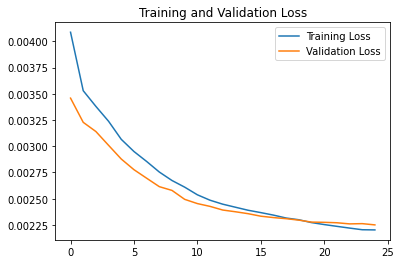

epoch: 25 Train loss: 0.002184730580472571 time: 0.7217428684234619
epoch: 25 Eval loss: 0.00222942978143692 time: 0.38800859451293945
epoch: 26 Train loss: 0.0021655612730291573 time: 0.7237129211425781
epoch: 26 Eval loss: 0.002223658375442028 time: 0.37726330757141113
epoch: 27 Train loss: 0.002154865733177539 time: 0.7276022434234619
epoch: 27 Eval loss: 0.0022170506417751312 time: 0.39242076873779297
epoch: 28 Train loss: 0.002147605569343867 time: 0.7257473468780518
epoch: 28 Eval loss: 0.0022025620564818382 time: 0.38713884353637695
epoch: 29 Train loss: 0.0021451004533942918 time: 0.7199616432189941
epoch: 29 Eval loss: 0.0022164853289723396 time: 0.39128565788269043
epoch: 30 Train loss: 0.0021354714351480507 time: 0.7374870777130127
epoch: 30 Eval loss: 0.0022196932695806026 time: 0.38110899925231934
epoch: 31 Train loss: 0.0021287987916384053 time: 0.7413341999053955
epoch: 31 Eval loss: 0.0022017485462129116 time: 0.3860743045806885
epoch: 32 Train loss: 0.00211441167487664

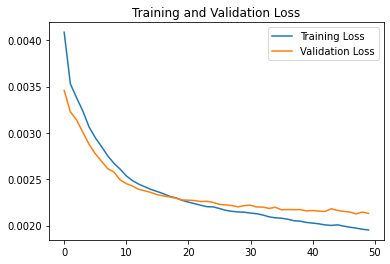

epoch: 50 Train loss: 0.001947879830370425 time: 0.7503833770751953
epoch: 50 Eval loss: 0.002123154466971755 time: 0.3859248161315918
epoch: 51 Train loss: 0.0019347331994266127 time: 0.7396869659423828
epoch: 51 Eval loss: 0.0021441844291985035 time: 0.3964376449584961
epoch: 52 Train loss: 0.0019351820203158696 time: 0.7454564571380615
epoch: 52 Eval loss: 0.0021297717466950417 time: 0.40276122093200684
epoch: 53 Train loss: 0.0019364077092677173 time: 0.725470781326294
epoch: 53 Eval loss: 0.002113206312060356 time: 0.3984715938568115
epoch: 54 Train loss: 0.0019208330885944716 time: 0.7443969249725342
epoch: 54 Eval loss: 0.002125389873981476 time: 0.42575669288635254
epoch: 55 Train loss: 0.0019097021688835097 time: 0.7350637912750244
epoch: 55 Eval loss: 0.00212839525192976 time: 0.399738073348999
epoch: 56 Train loss: 0.0019044190749512987 time: 0.7232530117034912
epoch: 56 Eval loss: 0.0021058821585029364 time: 0.41091227531433105
epoch: 57 Train loss: 0.0019007749001602279 ti

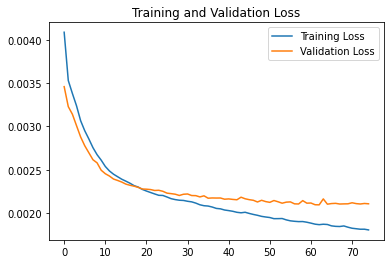

epoch: 75 Train loss: 0.0017999306464549854 time: 0.7397022247314453
epoch: 75 Eval loss: 0.002103545004501939 time: 0.4193227291107178
epoch: 76 Train loss: 0.0017903402043557021 time: 0.7332251071929932
epoch: 76 Eval loss: 0.002104436978697777 time: 0.4014294147491455
epoch: 77 Train loss: 0.0017837504754437757 time: 0.758800745010376
epoch: 77 Eval loss: 0.0020962224807590246 time: 0.3967263698577881
epoch: 78 Train loss: 0.0017817491047860026 time: 0.7439982891082764
epoch: 78 Eval loss: 0.0020992124918848276 time: 0.3999037742614746
epoch: 79 Train loss: 0.001774922078467208 time: 0.7308459281921387
epoch: 79 Eval loss: 0.0021039003040641546 time: 0.4304804801940918
epoch: 80 Train loss: 0.0017714165379264745 time: 0.7464888095855713
epoch: 80 Eval loss: 0.0020965090952813625 time: 0.41563892364501953
epoch: 81 Train loss: 0.0017774636194774797 time: 0.725020170211792
epoch: 81 Eval loss: 0.0020985123701393604 time: 0.40094900131225586
epoch: 82 Train loss: 0.0017738208005225983 

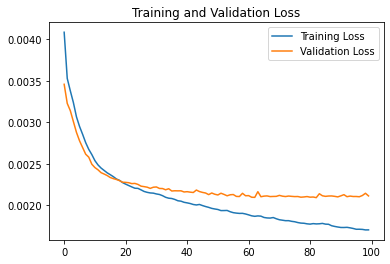

epoch: 100 Train loss: 0.0016988508422856568 time: 0.7658536434173584
epoch: 100 Eval loss: 0.002126032253727317 time: 0.4148294925689697
epoch: 101 Train loss: 0.0016965158968147017 time: 0.7575173377990723
epoch: 101 Eval loss: 0.0021055506076663733 time: 0.42919206619262695
epoch: 102 Train loss: 0.0017050793321113887 time: 0.7530417442321777
epoch: 102 Eval loss: 0.002090528141707182 time: 0.4182169437408447
epoch: 103 Train loss: 0.00169834883089975 time: 0.764756441116333
epoch: 103 Eval loss: 0.002111350651830435 time: 0.43833494186401367
epoch: 104 Train loss: 0.001693647364618897 time: 0.8062000274658203
epoch: 104 Eval loss: 0.00211168359965086 time: 0.43181586265563965
epoch: 105 Train loss: 0.0016828771755555587 time: 0.7601051330566406
epoch: 105 Eval loss: 0.0021134999115020037 time: 0.4331538677215576
epoch: 106 Train loss: 0.001678048234599156 time: 0.7768440246582031
epoch: 106 Eval loss: 0.0021423553116619587 time: 0.42188286781311035
epoch: 107 Train loss: 0.00167593

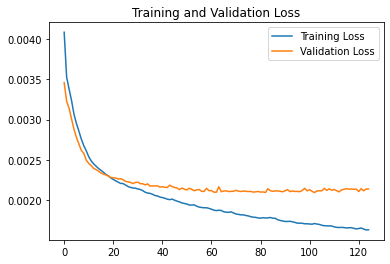

epoch: 125 Train loss: 0.0016253663199258706 time: 0.7785520553588867
epoch: 125 Eval loss: 0.0021102442406117916 time: 0.44646430015563965
epoch: 126 Train loss: 0.0016223822157318303 time: 0.7997965812683105
epoch: 126 Eval loss: 0.002136272145435214 time: 0.4250175952911377
epoch: 127 Train loss: 0.0016156013530278979 time: 0.7634921073913574
epoch: 127 Eval loss: 0.0021648984402418137 time: 0.4267885684967041
epoch: 128 Train loss: 0.0016150917672109728 time: 0.8112061023712158
epoch: 128 Eval loss: 0.00212302478030324 time: 0.44580984115600586
epoch: 129 Train loss: 0.0016090660140061733 time: 0.8163907527923584
epoch: 129 Eval loss: 0.00213936367072165 time: 0.44870972633361816
epoch: 130 Train loss: 0.0016020799767835455 time: 0.7950253486633301
epoch: 130 Eval loss: 0.0021213057916611433 time: 0.4359123706817627
epoch: 131 Train loss: 0.0016012182385902705 time: 0.7741589546203613
epoch: 131 Eval loss: 0.0021412598434835672 time: 0.43869709968566895
epoch: 132 Train loss: 0.001

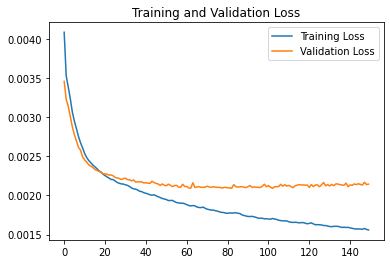

epoch: 150 Train loss: 0.00155711406067809 time: 0.7893621921539307
epoch: 150 Eval loss: 0.0021483581513166428 time: 0.4570779800415039
epoch: 151 Train loss: 0.0015569461586177088 time: 0.7978003025054932
epoch: 151 Eval loss: 0.00213601253926754 time: 0.4671897888183594
epoch: 152 Train loss: 0.0015603055035139737 time: 0.7780327796936035
epoch: 152 Eval loss: 0.0021458531264215708 time: 0.4612233638763428
epoch: 153 Train loss: 0.001562733832202454 time: 0.790076732635498
epoch: 153 Eval loss: 0.002146196085959673 time: 0.47293734550476074
Checking performance on test data
epoch: 154 Eval loss: 0.002534482370382585 time: 0.5117981433868408
epoch: 154 Eval loss1: 0.00236472506193245 Eval loss2: 0.0028507090027227342 Eval loss3: 0.0024636366269873374 time: 0.49225544929504395


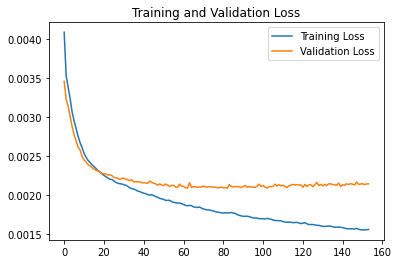

In [ ]:
av.lr=[0.005] #best Lr for this model
av.lstm_bidir=True
for lr in av.lr:
  av.LEARNING_RATE=lr
  av.model_name="LSTM_bi_dir" 
  run(fold, train_loader, val_loader, test_loader, tr_sz, test_sz, val_sz,model=OpenVaccineLSTM(av))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 Train loss: 0.005161854173671959 time: 0.8246891498565674
epoch: 0 Eval loss: 0.004884197376668453 time: 0.6799213886260986
epoch: 1 Train loss: 0.005026184041981935 time: 0.8475337028503418
epoch: 1 Eval loss: 0.004743662197142839 time: 0.7211275100708008
epoch: 2 Train loss: 0.004884225020571331 time: 0.8717544078826904
epoch: 2 Eval loss: 0.004600008483976126 time: 0.7033050060272217
epoch: 3 Train loss: 0.004740112409816952 time: 0.8367464542388916
epoch: 3 Eval loss: 0.0044511910527944565 time: 0.7205729484558105
epoch: 4 Train loss: 0.004586503157361182 time: 0.819685697555542
epoch: 4 Eval loss: 0.004293423146009445 time: 0.7036867141723633
epoch: 5 Train loss: 0.004424452103759151 time: 0.8304862976074219
epoch: 5 Eval loss: 0.004130297806113958 time: 0.695720911026001
epoch: 6 Train loss: 0.004261365139161091 time: 0.8395159244537354
epoch: 6 Eval loss: 0.0039724200032651424 time: 0.7046406269073486
epoch: 7 Train loss: 0.004105014542373564 time: 0.8489813804626465
ep

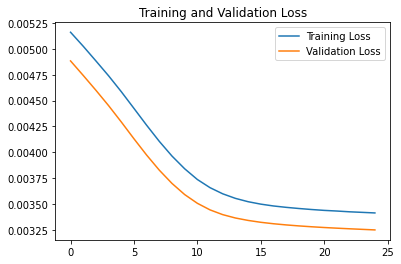

epoch: 25 Train loss: 0.003406893810679385 time: 0.8277561664581299
epoch: 25 Eval loss: 0.003242864040657878 time: 0.7245430946350098
epoch: 26 Train loss: 0.003401531634994066 time: 0.8701796531677246
epoch: 26 Eval loss: 0.0032383217476308346 time: 0.7406158447265625
epoch: 27 Train loss: 0.0033979916249256017 time: 0.8432824611663818
epoch: 27 Eval loss: 0.0032337368465960026 time: 0.73038649559021
epoch: 28 Train loss: 0.003392375777504054 time: 0.8486626148223877
epoch: 28 Eval loss: 0.003229764988645911 time: 0.7318534851074219
epoch: 29 Train loss: 0.003388119312304733 time: 0.8542056083679199
epoch: 29 Eval loss: 0.0032260711304843426 time: 0.736980676651001
epoch: 30 Train loss: 0.0033848482010558523 time: 0.8412103652954102
epoch: 30 Eval loss: 0.0032223896123468876 time: 0.7124404907226562
epoch: 31 Train loss: 0.003380582010339251 time: 0.8472750186920166
epoch: 31 Eval loss: 0.003218510653823614 time: 0.7307872772216797
epoch: 32 Train loss: 0.0033776152843148274 time: 0.

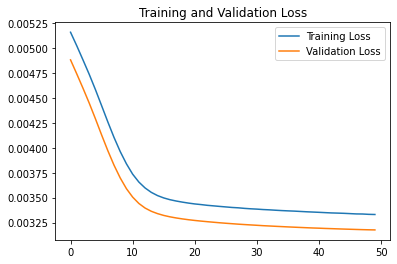

epoch: 50 Train loss: 0.003328479441862198 time: 0.8641970157623291
epoch: 50 Eval loss: 0.003174114739522338 time: 0.7488899230957031
epoch: 51 Train loss: 0.0033275638352541787 time: 0.87636399269104
epoch: 51 Eval loss: 0.0031726649031043053 time: 0.7514476776123047
epoch: 52 Train loss: 0.003325897147544934 time: 0.8696014881134033
epoch: 52 Eval loss: 0.00317162717692554 time: 0.7658257484436035
epoch: 53 Train loss: 0.003323758707063196 time: 0.9148399829864502
epoch: 53 Eval loss: 0.003170462092384696 time: 0.7569906711578369
epoch: 54 Train loss: 0.003321665687093793 time: 0.8973731994628906
epoch: 54 Eval loss: 0.003169445088133216 time: 0.7831106185913086
epoch: 55 Train loss: 0.0033209230278212045 time: 0.8886609077453613
epoch: 55 Eval loss: 0.0031684301793575287 time: 0.7688941955566406
epoch: 56 Train loss: 0.0033195519906225063 time: 0.8932194709777832
epoch: 56 Eval loss: 0.003167205024510622 time: 0.7346558570861816
epoch: 57 Train loss: 0.003317010188874506 time: 0.86

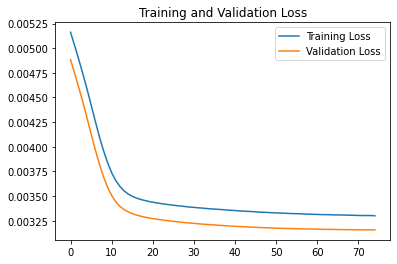

epoch: 75 Train loss: 0.003299714125568994 time: 0.9102573394775391
epoch: 75 Eval loss: 0.00315566873177886 time: 0.7878026962280273
epoch: 76 Train loss: 0.0032978962360508905 time: 0.9189422130584717
epoch: 76 Eval loss: 0.0031553292647004128 time: 0.7791545391082764
epoch: 77 Train loss: 0.0032980518443273643 time: 0.8938126564025879
epoch: 77 Eval loss: 0.0031551015563309193 time: 0.7794451713562012
epoch: 78 Train loss: 0.0032975144638685626 time: 0.9088177680969238
epoch: 78 Eval loss: 0.0031545679084956646 time: 0.8022079467773438
epoch: 79 Train loss: 0.0032970862542967576 time: 0.9137392044067383
epoch: 79 Eval loss: 0.0031543755903840065 time: 0.7569420337677002
epoch: 80 Train loss: 0.0032964232764740526 time: 0.8815286159515381
epoch: 80 Eval loss: 0.0031539106275886297 time: 0.7863588333129883
epoch: 81 Train loss: 0.0032950800078434582 time: 0.897554874420166
epoch: 81 Eval loss: 0.0031536505557596684 time: 0.7673587799072266
epoch: 82 Train loss: 0.0032940081932621885 t

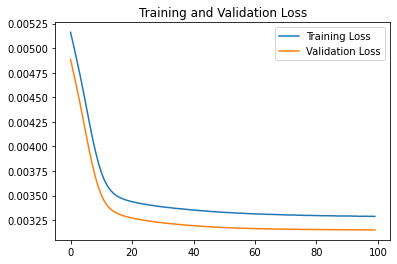

epoch: 100 Train loss: 0.0032879276329868213 time: 0.9260399341583252
epoch: 100 Eval loss: 0.003150148084387183 time: 0.8213441371917725
epoch: 101 Train loss: 0.003287756980143403 time: 0.9474761486053467
epoch: 101 Eval loss: 0.00315004657022655 time: 0.8100416660308838
epoch: 102 Train loss: 0.003288011590535455 time: 0.9172091484069824
epoch: 102 Eval loss: 0.003149802563712001 time: 0.7979562282562256
epoch: 103 Train loss: 0.0032871891715916643 time: 0.9224853515625
epoch: 103 Eval loss: 0.003149524098262191 time: 0.7826552391052246
epoch: 104 Train loss: 0.003285572154419733 time: 0.9051849842071533
epoch: 104 Eval loss: 0.003149656346067786 time: 0.7966012954711914
epoch: 105 Train loss: 0.003286166558219796 time: 0.9467177391052246
epoch: 105 Eval loss: 0.003149407682940364 time: 0.7909431457519531
epoch: 106 Train loss: 0.003285193328573739 time: 0.9516313076019287
epoch: 106 Eval loss: 0.0031494004651904106 time: 0.8063888549804688
epoch: 107 Train loss: 0.00328692877282203

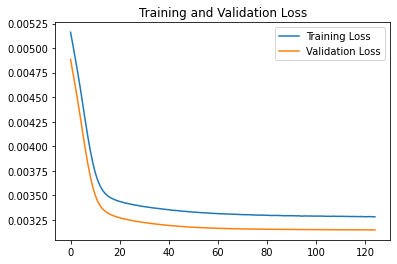

epoch: 125 Train loss: 0.003281360562183517 time: 0.9413251876831055
epoch: 125 Eval loss: 0.003146779490634799 time: 0.7926335334777832
epoch: 126 Train loss: 0.003281383220292139 time: 0.9467983245849609
epoch: 126 Eval loss: 0.0031466397922486067 time: 0.8120119571685791
epoch: 127 Train loss: 0.003280233966605453 time: 0.9310200214385986
epoch: 127 Eval loss: 0.0031468847300857306 time: 0.8260097503662109
epoch: 128 Train loss: 0.00328140668668772 time: 1.0064623355865479
epoch: 128 Eval loss: 0.003146881004795432 time: 0.8594317436218262
epoch: 129 Train loss: 0.0032811630794278178 time: 0.949540376663208
epoch: 129 Eval loss: 0.0031464840285480022 time: 0.8395678997039795
epoch: 130 Train loss: 0.0032792213916361386 time: 0.9735798835754395
epoch: 130 Eval loss: 0.003146279603242874 time: 0.8165726661682129
epoch: 131 Train loss: 0.0032802410586716727 time: 0.955366849899292
epoch: 131 Eval loss: 0.0031459257006645203 time: 0.8401670455932617
epoch: 132 Train loss: 0.003280146384

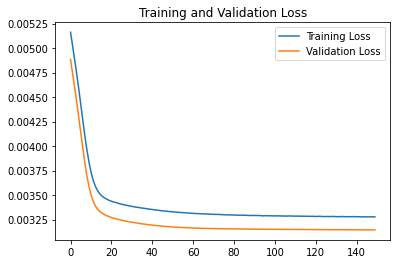

epoch: 150 Train loss: 0.0032765142560943843 time: 0.9978451728820801
epoch: 150 Eval loss: 0.0031444025225937366 time: 0.8707995414733887
epoch: 151 Train loss: 0.003275899984079396 time: 0.9632117748260498
epoch: 151 Eval loss: 0.0031444872729480267 time: 0.8404335975646973
epoch: 152 Train loss: 0.0032767112695221722 time: 0.9906957149505615
epoch: 152 Eval loss: 0.0031443459447473288 time: 0.8479869365692139
epoch: 153 Train loss: 0.0032767451132793544 time: 0.9625859260559082
epoch: 153 Eval loss: 0.0031440991442650557 time: 0.8298912048339844
epoch: 154 Train loss: 0.003277294957001587 time: 0.9820163249969482
epoch: 154 Eval loss: 0.003143948270007968 time: 0.8395407199859619
epoch: 155 Train loss: 0.0032766990148489243 time: 0.9965312480926514
epoch: 155 Eval loss: 0.003144199727103114 time: 0.8545043468475342
epoch: 156 Train loss: 0.0032758873122257825 time: 0.9857020378112793
epoch: 156 Eval loss: 0.0031442323233932257 time: 0.8514952659606934
epoch: 157 Train loss: 0.003276

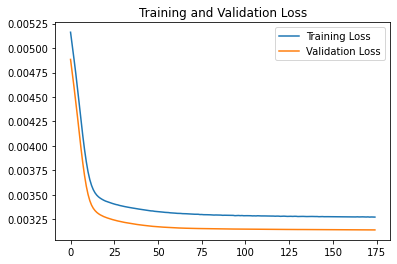

epoch: 175 Train loss: 0.00327383848730139 time: 1.0128991603851318
epoch: 175 Eval loss: 0.00314234453253448 time: 0.875988245010376
epoch: 176 Train loss: 0.0032741580735354287 time: 1.0005440711975098
epoch: 176 Eval loss: 0.003142647910863161 time: 0.8491923809051514
epoch: 177 Train loss: 0.0032741121315476357 time: 0.9850971698760986
epoch: 177 Eval loss: 0.0031422749161720276 time: 0.8869457244873047
epoch: 178 Train loss: 0.003273729368561939 time: 1.0175044536590576
epoch: 178 Eval loss: 0.0031421277672052383 time: 0.8720722198486328
epoch: 179 Train loss: 0.0032743073719588684 time: 0.9963674545288086
epoch: 179 Eval loss: 0.003142099827528 time: 0.8630533218383789
epoch: 180 Train loss: 0.0032727816390657467 time: 0.9766054153442383
epoch: 180 Eval loss: 0.0031424383632838726 time: 0.8530850410461426
epoch: 181 Train loss: 0.003273132435605908 time: 0.9957976341247559
epoch: 181 Eval loss: 0.003142155474051833 time: 0.8985891342163086
epoch: 182 Train loss: 0.003272094490855

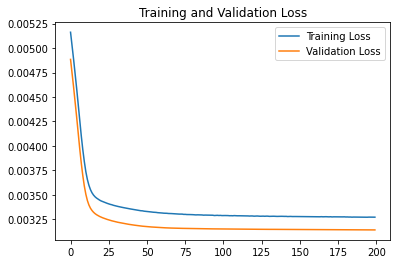

epoch: 200 Train loss: 0.003270260565967176 time: 0.9970541000366211
epoch: 200 Eval loss: 0.0031404688488692045 time: 0.8634011745452881
epoch: 201 Train loss: 0.0032699994110581337 time: 0.9884343147277832
epoch: 201 Eval loss: 0.0031404716428369284 time: 0.8748626708984375
epoch: 202 Train loss: 0.0032701261035204977 time: 1.0111596584320068
epoch: 202 Eval loss: 0.0031407158821821213 time: 0.9012942314147949
epoch: 203 Train loss: 0.0032693151831105416 time: 1.0488100051879883
epoch: 203 Eval loss: 0.003140553366392851 time: 0.8752803802490234
epoch: 204 Train loss: 0.0032701792679433747 time: 0.9974019527435303
epoch: 204 Eval loss: 0.0031405105255544186 time: 0.8696169853210449
epoch: 205 Train loss: 0.0032692535707852556 time: 0.9857072830200195
epoch: 205 Eval loss: 0.0031403801403939724 time: 0.8419885635375977
epoch: 206 Train loss: 0.0032705209125892592 time: 0.9811618328094482
epoch: 206 Eval loss: 0.0031405375339090824 time: 0.8803162574768066
epoch: 207 Train loss: 0.0032

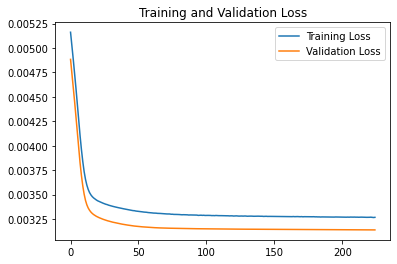

epoch: 225 Train loss: 0.0032679705325699853 time: 0.9970331192016602
epoch: 225 Eval loss: 0.003139205975458026 time: 0.8783793449401855
epoch: 226 Train loss: 0.003267600311069038 time: 1.0131547451019287
epoch: 226 Eval loss: 0.0031388408970087767 time: 0.8841507434844971
epoch: 227 Train loss: 0.003267370027507071 time: 0.9917099475860596
epoch: 227 Eval loss: 0.003138741012662649 time: 0.898648738861084
epoch: 228 Train loss: 0.0032682069956161217 time: 1.0065655708312988
epoch: 228 Eval loss: 0.003139162203297019 time: 0.8810276985168457
epoch: 229 Train loss: 0.003268074619071273 time: 0.9824187755584717
epoch: 229 Eval loss: 0.0031386180780828 time: 0.8645212650299072
epoch: 230 Train loss: 0.0032668215917685734 time: 1.0343635082244873
epoch: 230 Eval loss: 0.003138643456622958 time: 0.8562052249908447
epoch: 231 Train loss: 0.003266487769254549 time: 1.020052194595337
epoch: 231 Eval loss: 0.0031383722089231014 time: 0.8937022686004639
epoch: 232 Train loss: 0.003267345648529

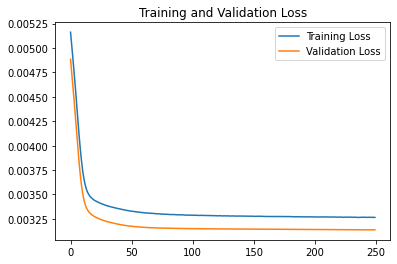

epoch: 250 Train loss: 0.0032656745804263538 time: 1.030867338180542
epoch: 250 Eval loss: 0.0031373347155749798 time: 0.8933506011962891
epoch: 251 Train loss: 0.0032646358273890805 time: 1.0983891487121582
epoch: 251 Eval loss: 0.003137608990073204 time: 0.9184036254882812
epoch: 252 Train loss: 0.0032638189621589106 time: 1.015967607498169
epoch: 252 Eval loss: 0.0031370841898024082 time: 0.9390749931335449
epoch: 253 Train loss: 0.003265532895544591 time: 0.9989535808563232
epoch: 253 Eval loss: 0.0031373004894703627 time: 0.8834874629974365
epoch: 254 Train loss: 0.0032643088622773203 time: 1.0018630027770996
epoch: 254 Eval loss: 0.0031373086385428905 time: 0.9210271835327148
epoch: 255 Train loss: 0.003264959298615276 time: 1.0417602062225342
epoch: 255 Eval loss: 0.0031370874494314194 time: 0.8668768405914307
epoch: 256 Train loss: 0.003264348755149808 time: 1.0126299858093262
epoch: 256 Eval loss: 0.0031371000222861767 time: 0.929145097732544
epoch: 257 Train loss: 0.003264429

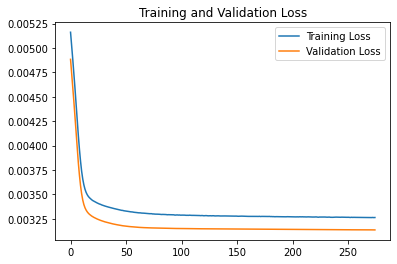

epoch: 275 Train loss: 0.0032621845277067034 time: 1.020437479019165
epoch: 275 Eval loss: 0.003135834587737918 time: 0.9331085681915283
epoch: 276 Train loss: 0.0032626898113511053 time: 1.0579402446746826
epoch: 276 Eval loss: 0.003136173589155078 time: 0.9077174663543701
epoch: 277 Train loss: 0.0032623248567522772 time: 1.0755023956298828
epoch: 277 Eval loss: 0.003135720966383815 time: 0.9087264537811279
epoch: 278 Train loss: 0.0032637490844476254 time: 1.0430643558502197
epoch: 278 Eval loss: 0.003136252984404564 time: 0.9182171821594238
epoch: 279 Train loss: 0.003262182441804874 time: 1.0287072658538818
epoch: 279 Eval loss: 0.003135866019874811 time: 0.9075045585632324
epoch: 280 Train loss: 0.0032629218679296273 time: 1.056311845779419
epoch: 280 Eval loss: 0.0031358913984149694 time: 0.9293270111083984
epoch: 281 Train loss: 0.003262007903969298 time: 1.0437748432159424
epoch: 281 Eval loss: 0.0031357738189399242 time: 0.9314780235290527
epoch: 282 Train loss: 0.00326255751

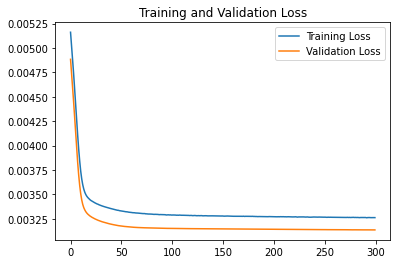

epoch: 300 Train loss: 0.0032611973746659354 time: 1.0236074924468994
epoch: 300 Eval loss: 0.0031346359755843878 time: 0.9067807197570801
epoch: 301 Train loss: 0.0032610423660862373 time: 1.1305005550384521
epoch: 301 Eval loss: 0.0031345642637461424 time: 0.9534735679626465
epoch: 302 Train loss: 0.003261293951920637 time: 1.1104459762573242
epoch: 302 Eval loss: 0.003134888131171465 time: 0.9442195892333984
epoch: 303 Train loss: 0.003260461338131655 time: 1.0631613731384277
epoch: 303 Eval loss: 0.00313451886177063 time: 0.9331872463226318
epoch: 304 Train loss: 0.0032602160360765166 time: 1.0873751640319824
epoch: 304 Eval loss: 0.003134544938802719 time: 0.9625544548034668
epoch: 305 Train loss: 0.003259671719994132 time: 1.0950820446014404
epoch: 305 Eval loss: 0.0031344513408839703 time: 0.9264719486236572
epoch: 306 Train loss: 0.003258906063653874 time: 1.0656862258911133
epoch: 306 Eval loss: 0.0031345789320766926 time: 0.9559383392333984
epoch: 307 Train loss: 0.0032598584

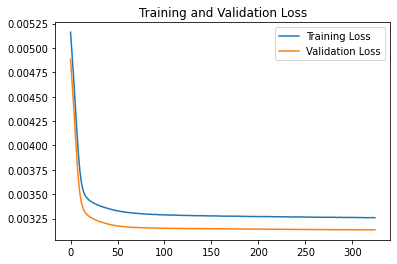

epoch: 325 Train loss: 0.0032591151492384995 time: 1.1056151390075684
epoch: 325 Eval loss: 0.0031329537741839886 time: 0.954200267791748
epoch: 326 Train loss: 0.0032587868282905504 time: 1.073735237121582
epoch: 326 Eval loss: 0.0031330387573689222 time: 0.9735159873962402
epoch: 327 Train loss: 0.003257595309018046 time: 1.0400421619415283
epoch: 327 Eval loss: 0.0031334501691162586 time: 0.9757852554321289
epoch: 328 Train loss: 0.003258755591910655 time: 1.0719475746154785
epoch: 328 Eval loss: 0.00313345855101943 time: 0.9723207950592041
epoch: 329 Train loss: 0.003257007527956291 time: 1.0790941715240479
epoch: 329 Eval loss: 0.0031330976635217667 time: 0.9710719585418701
epoch: 330 Train loss: 0.0032577148833404165 time: 1.0867760181427002
epoch: 330 Eval loss: 0.0031330648344010115 time: 0.9868946075439453
epoch: 331 Train loss: 0.0032583377336266785 time: 1.1021156311035156
epoch: 331 Eval loss: 0.003133191494271159 time: 0.95475172996521
epoch: 332 Train loss: 0.003258083931

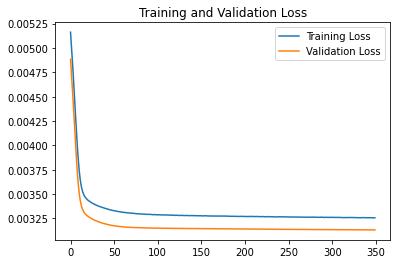

epoch: 350 Train loss: 0.003256539920913683 time: 1.1297802925109863
epoch: 350 Eval loss: 0.0031320638954639435 time: 1.0127253532409668
epoch: 351 Train loss: 0.0032570609270431237 time: 1.1195769309997559
epoch: 351 Eval loss: 0.0031318776309490204 time: 0.9946119785308838
epoch: 352 Train loss: 0.0032567768011401853 time: 1.1443195343017578
epoch: 352 Eval loss: 0.0031320617999881506 time: 1.0131163597106934
epoch: 353 Train loss: 0.003256421102730725 time: 1.1220791339874268
epoch: 353 Eval loss: 0.0031320189591497183 time: 0.975872278213501
epoch: 354 Train loss: 0.0032557657645234704 time: 1.121483564376831
epoch: 354 Eval loss: 0.003131781704723835 time: 1.0267658233642578
epoch: 355 Train loss: 0.003255913707110721 time: 1.1256892681121826
epoch: 355 Eval loss: 0.003132015932351351 time: 0.9821357727050781
epoch: 356 Train loss: 0.0032563883801457762 time: 1.1615281105041504
epoch: 356 Eval loss: 0.0031318734399974346 time: 0.9944829940795898
epoch: 357 Train loss: 0.003255661

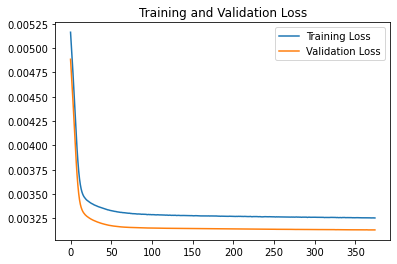

epoch: 375 Train loss: 0.0032541422810558676 time: 1.1243419647216797
epoch: 375 Eval loss: 0.003131076693534851 time: 1.0088732242584229
epoch: 376 Train loss: 0.0032542044930779297 time: 1.1230552196502686
epoch: 376 Eval loss: 0.003131040371954441 time: 0.975907564163208
epoch: 377 Train loss: 0.0032532358524158976 time: 1.1381008625030518
epoch: 377 Eval loss: 0.0031309358309954405 time: 1.0064752101898193
epoch: 378 Train loss: 0.0032547040926398465 time: 1.1430294513702393
epoch: 378 Eval loss: 0.003130729775875807 time: 0.9878828525543213
epoch: 379 Train loss: 0.0032548187129453725 time: 1.128162145614624
epoch: 379 Eval loss: 0.0031309672631323338 time: 1.0194554328918457
epoch: 380 Train loss: 0.003254914560134434 time: 1.1295247077941895
epoch: 380 Eval loss: 0.0031306417658925056 time: 1.0120537281036377
epoch: 381 Train loss: 0.0032540926626661005 time: 1.1381256580352783
epoch: 381 Eval loss: 0.003130510449409485 time: 1.0092239379882812
epoch: 382 Train loss: 0.003255700

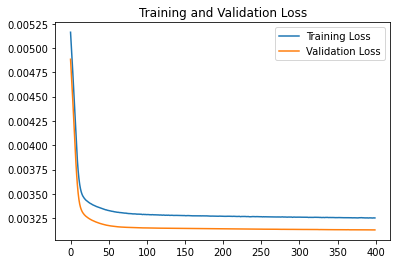

epoch: 400 Train loss: 0.003252354063491287 time: 1.150820016860962
epoch: 400 Eval loss: 0.0031297728419303894 time: 1.0232875347137451
epoch: 401 Train loss: 0.0032524147110869774 time: 1.1489121913909912
epoch: 401 Eval loss: 0.0031298650428652763 time: 1.0356247425079346
epoch: 402 Train loss: 0.0032532894340191404 time: 1.164717435836792
epoch: 402 Eval loss: 0.0031301218550652266 time: 1.051954984664917
epoch: 403 Train loss: 0.00325294400867619 time: 1.1649179458618164
epoch: 403 Eval loss: 0.003130116267129779 time: 1.0102155208587646
epoch: 404 Train loss: 0.0032516313767287156 time: 1.1467463970184326
epoch: 404 Eval loss: 0.003129820805042982 time: 1.0633063316345215
epoch: 405 Train loss: 0.0032522606672368754 time: 1.1352388858795166
epoch: 405 Eval loss: 0.003129545133560896 time: 1.0132551193237305
epoch: 406 Train loss: 0.0032521383290945805 time: 1.1662042140960693
epoch: 406 Eval loss: 0.0031294147484004498 time: 1.0175762176513672
epoch: 407 Train loss: 0.00325132605

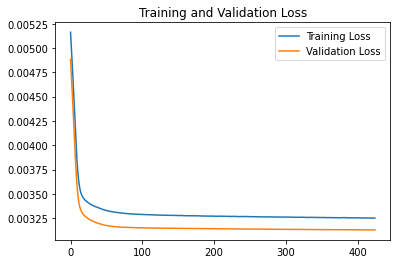

epoch: 425 Train loss: 0.003250374542655177 time: 1.1790897846221924
epoch: 425 Eval loss: 0.003128337673842907 time: 1.0800507068634033
epoch: 426 Train loss: 0.0032515789684452513 time: 1.1641809940338135
epoch: 426 Eval loss: 0.00312860868871212 time: 1.0165486335754395
epoch: 427 Train loss: 0.003250012351876273 time: 1.182941198348999
epoch: 427 Eval loss: 0.0031292843632400036 time: 1.0494482517242432
epoch: 428 Train loss: 0.003250293114262512 time: 1.1665327548980713
epoch: 428 Eval loss: 0.003129122545942664 time: 1.0322134494781494
epoch: 429 Train loss: 0.0032506881058476833 time: 1.1968348026275635
epoch: 429 Eval loss: 0.0031287125311791897 time: 1.0187814235687256
epoch: 430 Train loss: 0.0032512813102541947 time: 1.157686710357666
epoch: 430 Eval loss: 0.0031286764424294233 time: 1.0624375343322754
epoch: 431 Train loss: 0.0032504162085442195 time: 1.170062780380249
epoch: 431 Eval loss: 0.003128903452306986 time: 1.048367977142334
epoch: 432 Train loss: 0.00325104646378

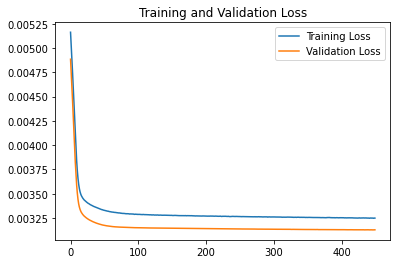

epoch: 450 Train loss: 0.0032484493074141775 time: 1.200211524963379
epoch: 450 Eval loss: 0.0031285143923014402 time: 1.0528898239135742
epoch: 451 Train loss: 0.0032475699172766713 time: 1.221299648284912
epoch: 451 Eval loss: 0.0031281744595617056 time: 1.0748004913330078
epoch: 452 Train loss: 0.0032479327338261242 time: 1.2390756607055664
epoch: 452 Eval loss: 0.003128131851553917 time: 1.0681266784667969
epoch: 453 Train loss: 0.0032485387665288864 time: 1.1988744735717773
epoch: 453 Eval loss: 0.0031279511749744415 time: 1.0887532234191895
epoch: 454 Train loss: 0.0032475499708404273 time: 1.211745262145996
epoch: 454 Eval loss: 0.0031283064745366573 time: 1.074061393737793
epoch: 455 Train loss: 0.0032490284319833403 time: 1.2185304164886475
epoch: 455 Eval loss: 0.0031282780691981316 time: 1.0645616054534912
epoch: 456 Train loss: 0.0032484616924562896 time: 1.2126905918121338
epoch: 456 Eval loss: 0.003127661067992449 time: 1.0959138870239258
epoch: 457 Train loss: 0.00324808

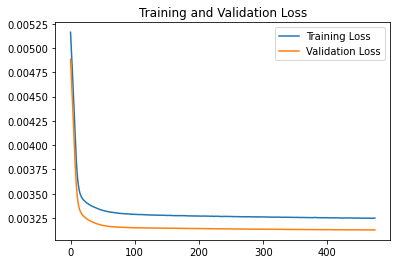

epoch: 475 Train loss: 0.003248200641842339 time: 1.3131604194641113
epoch: 475 Eval loss: 0.0031276519875973463 time: 1.1221792697906494
epoch: 476 Train loss: 0.0032460524236957752 time: 1.2579336166381836
epoch: 476 Eval loss: 0.0031280722469091415 time: 1.127856731414795
epoch: 477 Train loss: 0.003247159255354006 time: 1.2548105716705322
epoch: 477 Eval loss: 0.0031278093811124563 time: 1.1159133911132812
epoch: 478 Train loss: 0.0032473141857123854 time: 1.2891623973846436
epoch: 478 Eval loss: 0.003127339296042919 time: 1.1768953800201416
epoch: 479 Train loss: 0.003247956017705295 time: 1.2873399257659912
epoch: 479 Eval loss: 0.003127718809992075 time: 1.132042407989502
epoch: 480 Train loss: 0.003246971237377858 time: 1.2876372337341309
epoch: 480 Eval loss: 0.0031276929657906294 time: 1.1977946758270264
epoch: 481 Train loss: 0.003248171856397093 time: 1.5492353439331055
epoch: 481 Eval loss: 0.00312767899595201 time: 1.2284669876098633
epoch: 482 Train loss: 0.0032476161721

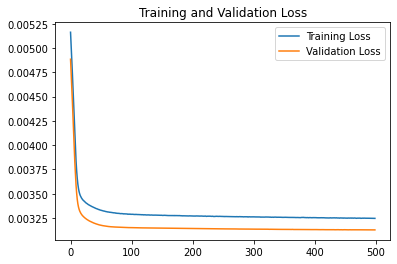

epoch: 500 Train loss: 0.0032451001573631038 time: 1.379072666168213
epoch: 500 Eval loss: 0.0031271539628505707 time: 1.217890739440918
epoch: 501 Train loss: 0.003246304061677721 time: 1.3723785877227783
epoch: 501 Eval loss: 0.0031268857419490814 time: 1.1900274753570557
epoch: 502 Train loss: 0.003245965415515716 time: 1.3184113502502441
epoch: 502 Eval loss: 0.0031262363772839308 time: 1.1651177406311035
epoch: 503 Train loss: 0.00324596090475301 time: 1.314330816268921
epoch: 503 Eval loss: 0.0031265360303223133 time: 1.1493911743164062
epoch: 504 Train loss: 0.003245363450321521 time: 1.284470796585083
epoch: 504 Eval loss: 0.0031266852747648954 time: 1.154906988143921
epoch: 505 Train loss: 0.003245580983808556 time: 1.322749376296997
epoch: 505 Eval loss: 0.003126556985080242 time: 1.162684679031372
epoch: 506 Train loss: 0.0032460497902447156 time: 1.3278121948242188
epoch: 506 Eval loss: 0.0031262943521142006 time: 1.1695523262023926
epoch: 507 Train loss: 0.0032463417904270

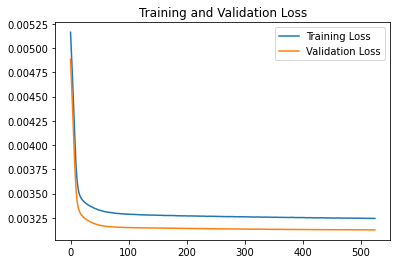

epoch: 525 Train loss: 0.003245278006567834 time: 1.753699541091919
epoch: 525 Eval loss: 0.0031262363772839308 time: 1.1675105094909668
epoch: 526 Train loss: 0.0032451947790848408 time: 2.4596176147460938
epoch: 526 Eval loss: 0.0031259215902537107 time: 1.3414294719696045
epoch: 527 Train loss: 0.0032440941008370066 time: 2.591930866241455
epoch: 527 Eval loss: 0.003125686664134264 time: 1.2737374305725098
epoch: 528 Train loss: 0.0032437789471443557 time: 1.4038164615631104
epoch: 528 Eval loss: 0.0031265034340322018 time: 1.2868328094482422
epoch: 529 Train loss: 0.003244781301194706 time: 1.3790192604064941
epoch: 529 Eval loss: 0.003125794231891632 time: 1.205233097076416
epoch: 530 Train loss: 0.0032453718200026118 time: 1.3248071670532227
epoch: 530 Eval loss: 0.003126241732388735 time: 1.1878199577331543
epoch: 531 Train loss: 0.0032441579555067593 time: 1.322943925857544
epoch: 531 Eval loss: 0.00312617514282465 time: 1.2221393585205078
epoch: 532 Train loss: 0.0032445359730

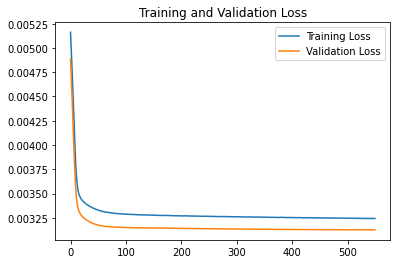

epoch: 550 Train loss: 0.003242974258366115 time: 1.3192665576934814
epoch: 550 Eval loss: 0.003125638235360384 time: 1.19283127784729
epoch: 551 Train loss: 0.0032423133664452393 time: 1.3349530696868896
epoch: 551 Eval loss: 0.003125739051029086 time: 1.221938133239746
epoch: 552 Train loss: 0.0032436469617061 time: 1.343665361404419
epoch: 552 Eval loss: 0.003125375136733055 time: 1.19075608253479
epoch: 553 Train loss: 0.003242176505211457 time: 1.3279986381530762
epoch: 553 Eval loss: 0.0031258377712219954 time: 1.1857779026031494
epoch: 554 Train loss: 0.0032429363471003655 time: 1.3518738746643066
epoch: 554 Eval loss: 0.0031253057532012463 time: 1.1796424388885498
epoch: 555 Train loss: 0.0032416647031238387 time: 1.3032598495483398
epoch: 555 Eval loss: 0.0031257392838597298 time: 1.2056105136871338
epoch: 556 Train loss: 0.003241209011795431 time: 1.353499412536621
epoch: 556 Eval loss: 0.0031251420732587576 time: 1.2038695812225342
epoch: 557 Train loss: 0.003241436114357108

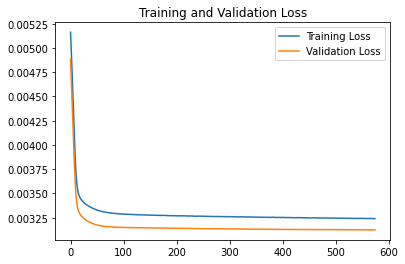

epoch: 575 Train loss: 0.003242289978270977 time: 1.346879243850708
epoch: 575 Eval loss: 0.003125058487057686 time: 1.191772699356079
epoch: 576 Train loss: 0.0032420115625242966 time: 1.3569278717041016
epoch: 576 Eval loss: 0.003125016577541828 time: 1.2084729671478271
epoch: 577 Train loss: 0.003241239387740822 time: 1.3584928512573242
epoch: 577 Eval loss: 0.003124697133898735 time: 1.2353489398956299
epoch: 578 Train loss: 0.0032406749166320106 time: 1.3900411128997803
epoch: 578 Eval loss: 0.0031246747821569443 time: 1.2533133029937744
epoch: 579 Train loss: 0.003241567056844449 time: 1.4177193641662598
epoch: 579 Eval loss: 0.003124811453744769 time: 1.201122760772705
epoch: 580 Train loss: 0.0032411396034120574 time: 1.3602745532989502
epoch: 580 Eval loss: 0.0031249094754457474 time: 1.2366833686828613
epoch: 581 Train loss: 0.0032413251183060106 time: 1.3539886474609375
epoch: 581 Eval loss: 0.0031245811842381954 time: 1.2064857482910156
epoch: 582 Train loss: 0.003240538107

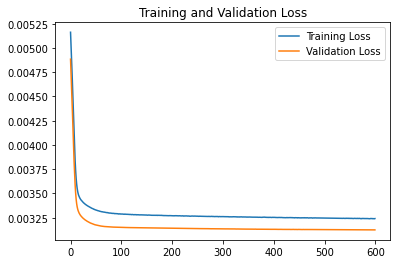

epoch: 600 Train loss: 0.003240454488956188 time: 1.3835277557373047
epoch: 600 Eval loss: 0.003123871749266982 time: 1.2454514503479004
epoch: 601 Train loss: 0.0032398083287169823 time: 1.3931660652160645
epoch: 601 Eval loss: 0.0031242016702890396 time: 1.2271616458892822
epoch: 602 Train loss: 0.0032398106753565403 time: 1.398622989654541
epoch: 602 Eval loss: 0.0031240032985806465 time: 1.2650985717773438
epoch: 603 Train loss: 0.0032388009945760144 time: 1.4244091510772705
epoch: 603 Eval loss: 0.003124099923297763 time: 1.2826495170593262
epoch: 604 Train loss: 0.003239300229105111 time: 1.3696961402893066
epoch: 604 Eval loss: 0.0031240142416208982 time: 1.2407054901123047
epoch: 605 Train loss: 0.0032385677907514863 time: 1.3819658756256104
epoch: 605 Eval loss: 0.00312392832711339 time: 1.23921799659729
epoch: 606 Train loss: 0.0032390038485289245 time: 1.3876478672027588
epoch: 606 Eval loss: 0.003124197479337454 time: 1.2231848239898682
epoch: 607 Train loss: 0.003241328690

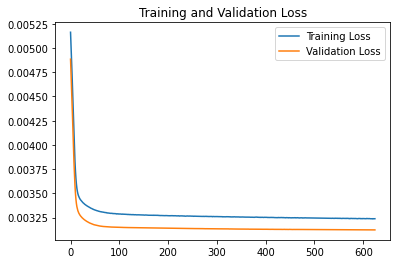

epoch: 625 Train loss: 0.0032385616894886355 time: 1.409825325012207
epoch: 625 Eval loss: 0.0031239015515893698 time: 1.2570521831512451
epoch: 626 Train loss: 0.0032378815290496107 time: 1.4106874465942383
epoch: 626 Eval loss: 0.003123524133116007 time: 1.2770802974700928
epoch: 627 Train loss: 0.003237941472653433 time: 1.4243152141571045
epoch: 627 Eval loss: 0.003123249625787139 time: 1.2573621273040771
epoch: 628 Train loss: 0.003239370185037715 time: 1.445070743560791
epoch: 628 Eval loss: 0.003123721806332469 time: 1.2956414222717285
epoch: 629 Train loss: 0.0032384199785331 time: 1.4135608673095703
epoch: 629 Eval loss: 0.003123755566775799 time: 1.2828388214111328
epoch: 630 Train loss: 0.00323821412609631 time: 1.4341051578521729
epoch: 630 Eval loss: 0.0031231276225298643 time: 1.283761978149414
epoch: 631 Train loss: 0.0032386885123198636 time: 1.4624576568603516
epoch: 631 Eval loss: 0.0031234226189553738 time: 1.3010914325714111
epoch: 632 Train loss: 0.0032374806708655

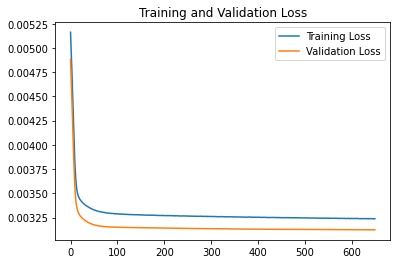

epoch: 650 Train loss: 0.0032377560099070258 time: 1.4909825325012207
epoch: 650 Eval loss: 0.003122869413346052 time: 1.3511857986450195
epoch: 651 Train loss: 0.0032363408298108627 time: 1.4764044284820557
epoch: 651 Eval loss: 0.0031230426393449306 time: 1.336421251296997
epoch: 652 Train loss: 0.003237707330173082 time: 1.4556453227996826
epoch: 652 Eval loss: 0.003122742986306548 time: 1.331160306930542
epoch: 653 Train loss: 0.0032374291490903572 time: 1.4731087684631348
epoch: 653 Eval loss: 0.0031226309947669506 time: 1.2967450618743896
epoch: 654 Train loss: 0.00323679615610645 time: 1.4948914051055908
epoch: 654 Eval loss: 0.0031230198219418526 time: 1.326549768447876
epoch: 655 Train loss: 0.003236782571670786 time: 1.4750008583068848
epoch: 655 Eval loss: 0.003122486639767885 time: 1.374711275100708
epoch: 656 Train loss: 0.003236224358267463 time: 1.5381309986114502
epoch: 656 Eval loss: 0.0031227488070726395 time: 1.375375747680664
epoch: 657 Train loss: 0.003236527961278

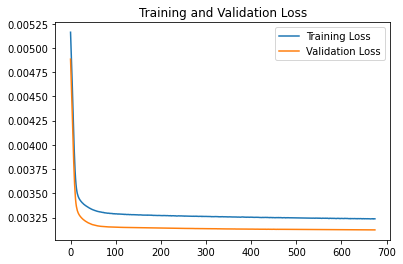

epoch: 675 Train loss: 0.003235920572739782 time: 1.4493718147277832
epoch: 675 Eval loss: 0.00312208104878664 time: 1.3279480934143066
epoch: 676 Train loss: 0.0032368797225484905 time: 1.4699738025665283
epoch: 676 Eval loss: 0.0031223397236317396 time: 1.3249638080596924
epoch: 677 Train loss: 0.003235110408469239 time: 1.4875574111938477
epoch: 677 Eval loss: 0.0031224375125020742 time: 1.3454110622406006
epoch: 678 Train loss: 0.003235771065726159 time: 1.5312488079071045
epoch: 678 Eval loss: 0.0031227744184434414 time: 1.3186109066009521
epoch: 679 Train loss: 0.003235448663524651 time: 1.533268690109253
epoch: 679 Eval loss: 0.003121880581602454 time: 1.3804152011871338
epoch: 680 Train loss: 0.003236767944284207 time: 1.5107176303863525
epoch: 680 Eval loss: 0.0031220149248838425 time: 1.354889154434204
epoch: 681 Train loss: 0.0032371799620430613 time: 1.5042507648468018
epoch: 681 Eval loss: 0.0031221339013427496 time: 1.3361294269561768
epoch: 682 Train loss: 0.003237202098

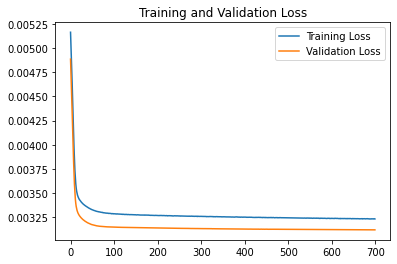

epoch: 700 Train loss: 0.0032348026336543097 time: 1.5117745399475098
epoch: 700 Eval loss: 0.003121576737612486 time: 1.3702120780944824
epoch: 701 Train loss: 0.0032349565732093205 time: 1.5006444454193115
epoch: 701 Eval loss: 0.0031213094480335712 time: 1.3729794025421143
epoch: 702 Train loss: 0.0032348706340539486 time: 1.5384693145751953
epoch: 702 Eval loss: 0.003121255664154887 time: 1.4020910263061523
epoch: 703 Train loss: 0.0032335773749197143 time: 1.521470546722412
epoch: 703 Eval loss: 0.0031213618349283934 time: 1.3720746040344238
epoch: 704 Train loss: 0.0032339087725728618 time: 1.5239334106445312
epoch: 704 Eval loss: 0.0031211646273732185 time: 1.371541976928711
epoch: 705 Train loss: 0.0032327633517307873 time: 1.4705147743225098
epoch: 705 Eval loss: 0.003121486632153392 time: 1.348909854888916
epoch: 706 Train loss: 0.003234029129108419 time: 1.5145857334136963
epoch: 706 Eval loss: 0.0031216475181281567 time: 1.3582580089569092
epoch: 707 Train loss: 0.003234241

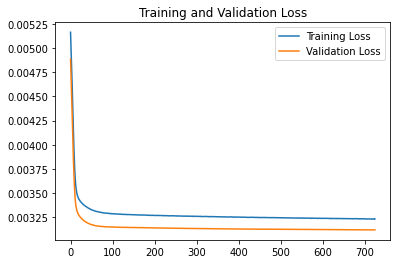

epoch: 725 Train loss: 0.003233816627859548 time: 1.5977680683135986
epoch: 725 Eval loss: 0.003120474051684141 time: 1.4042751789093018
epoch: 726 Train loss: 0.003233376372204678 time: 1.5622265338897705
epoch: 726 Eval loss: 0.003121304092928767 time: 1.4266114234924316
epoch: 727 Train loss: 0.003233384246484084 time: 1.693293809890747
epoch: 727 Eval loss: 0.0031215394847095013 time: 1.4387462139129639
epoch: 728 Train loss: 0.0032320743001352146 time: 1.5227906703948975
epoch: 728 Eval loss: 0.0031205415725708008 time: 1.3843741416931152
epoch: 729 Train loss: 0.003232811588210592 time: 1.5500569343566895
epoch: 729 Eval loss: 0.0031202053651213646 time: 1.4204351902008057
epoch: 730 Train loss: 0.003232908713014524 time: 1.574178695678711
epoch: 730 Eval loss: 0.003121232148259878 time: 1.415592908859253
epoch: 731 Train loss: 0.0032339837607436293 time: 1.5995404720306396
epoch: 731 Eval loss: 0.0031209662556648254 time: 1.4033663272857666
epoch: 732 Train loss: 0.0032331770903

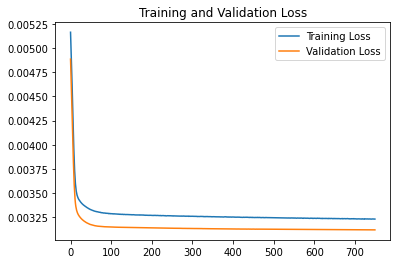

epoch: 750 Train loss: 0.003232523707684361 time: 2.3599939346313477
epoch: 750 Eval loss: 0.0031204873230308294 time: 1.4041266441345215
epoch: 751 Train loss: 0.0032306779974506073 time: 2.9566943645477295
epoch: 751 Eval loss: 0.0031199678778648376 time: 1.7938010692596436
epoch: 752 Train loss: 0.0032320717449054737 time: 1.5576035976409912
epoch: 752 Eval loss: 0.0031202654354274273 time: 1.468679666519165
epoch: 753 Train loss: 0.0032313419921504542 time: 1.613673210144043
epoch: 753 Eval loss: 0.003120254259556532 time: 1.4172682762145996
epoch: 754 Train loss: 0.0032316143066342838 time: 1.541062593460083
epoch: 754 Eval loss: 0.003120195586234331 time: 1.404808521270752
epoch: 755 Train loss: 0.003232272147923734 time: 1.5240416526794434
epoch: 755 Eval loss: 0.0031204228289425373 time: 1.3940093517303467
epoch: 756 Train loss: 0.0032319452349595197 time: 1.5216588973999023
epoch: 756 Eval loss: 0.0031200600787997246 time: 1.4093685150146484
epoch: 757 Train loss: 0.0032301653

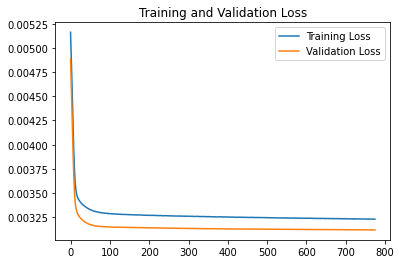

epoch: 775 Train loss: 0.0032301855942500025 time: 1.6111841201782227
epoch: 775 Eval loss: 0.00311996485106647 time: 1.4298121929168701
epoch: 776 Train loss: 0.003230844713154323 time: 1.6210365295410156
epoch: 776 Eval loss: 0.0031202572863548994 time: 1.4810779094696045
epoch: 777 Train loss: 0.0032298962014449444 time: 1.6172685623168945
epoch: 777 Eval loss: 0.00312003749422729 time: 1.4752373695373535
epoch: 778 Train loss: 0.00322942244099194 time: 1.6775758266448975
epoch: 778 Eval loss: 0.0031194742769002914 time: 1.4564638137817383
epoch: 779 Train loss: 0.003231689868428054 time: 1.6113710403442383
epoch: 779 Eval loss: 0.0031197532080113888 time: 1.4578282833099365
epoch: 780 Train loss: 0.0032299165129140084 time: 1.6129517555236816
epoch: 780 Eval loss: 0.003120576497167349 time: 1.4711406230926514
epoch: 781 Train loss: 0.0032303362745834045 time: 1.6585440635681152
epoch: 781 Eval loss: 0.0031196395866572857 time: 1.50612211227417
epoch: 782 Train loss: 0.0032306092409

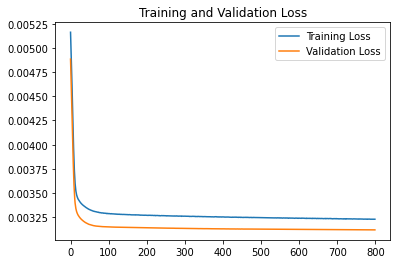

epoch: 800 Train loss: 0.003229882877747009 time: 1.5813095569610596
epoch: 800 Eval loss: 0.0031195692718029022 time: 1.476503849029541
epoch: 801 Train loss: 0.0032282602025663653 time: 1.652101993560791
epoch: 801 Eval loss: 0.00311921420507133 time: 1.468445062637329
epoch: 802 Train loss: 0.0032296323087897512 time: 1.6062126159667969
epoch: 802 Eval loss: 0.0031184430699795485 time: 1.4458484649658203
epoch: 803 Train loss: 0.0032289214855938343 time: 1.641484022140503
epoch: 803 Eval loss: 0.003118867054581642 time: 1.495807409286499
epoch: 804 Train loss: 0.00322985688219546 time: 1.6267306804656982
epoch: 804 Eval loss: 0.003119572065770626 time: 1.4829299449920654
epoch: 805 Train loss: 0.00322976731878566 time: 1.6343820095062256
epoch: 805 Eval loss: 0.0031186442356556654 time: 1.495185375213623
epoch: 806 Train loss: 0.0032293728747497183 time: 1.6183459758758545
epoch: 806 Eval loss: 0.0031191008165478706 time: 1.4664366245269775
epoch: 807 Train loss: 0.00322928432821706

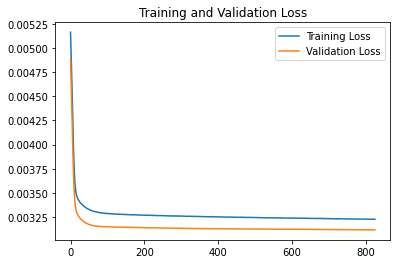

epoch: 825 Train loss: 0.0032287205089525707 time: 1.603203535079956
epoch: 825 Eval loss: 0.0031183958053588867 time: 1.4629333019256592
epoch: 826 Train loss: 0.003228521852877092 time: 1.6611614227294922
epoch: 826 Eval loss: 0.0031185082625597715 time: 1.5494792461395264
epoch: 827 Train loss: 0.003227471053756754 time: 1.6143736839294434
epoch: 827 Eval loss: 0.003118540160357952 time: 1.5153782367706299
epoch: 828 Train loss: 0.003226905357180618 time: 1.6973927021026611
epoch: 828 Eval loss: 0.003118639811873436 time: 1.5265941619873047
epoch: 829 Train loss: 0.0032269570614722144 time: 1.6835732460021973
epoch: 829 Eval loss: 0.0031177958007901907 time: 1.5361764430999756
epoch: 830 Train loss: 0.003228329454507102 time: 1.6777050495147705
epoch: 830 Eval loss: 0.003117509186267853 time: 1.5147051811218262
epoch: 831 Train loss: 0.003228117552955007 time: 1.736762285232544
epoch: 831 Eval loss: 0.003118612803518772 time: 1.5880687236785889
epoch: 832 Train loss: 0.0032283468196

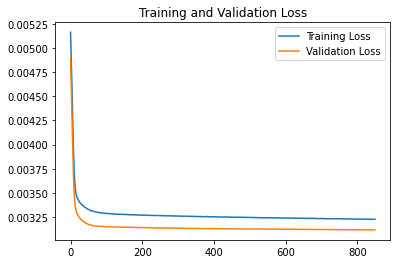

epoch: 850 Train loss: 0.0032270170832973556 time: 1.674947738647461
epoch: 850 Eval loss: 0.003117665648460388 time: 1.5660881996154785
epoch: 851 Train loss: 0.0032260562386934107 time: 1.6726210117340088
epoch: 851 Eval loss: 0.003117644926533103 time: 1.5533907413482666
epoch: 852 Train loss: 0.0032267328530993255 time: 1.7074813842773438
epoch: 852 Eval loss: 0.0031176162883639336 time: 1.5257971286773682
epoch: 853 Train loss: 0.0032268340975593708 time: 1.6798343658447266
epoch: 853 Eval loss: 0.0031177187338471413 time: 1.5068328380584717
epoch: 854 Train loss: 0.003226762577200395 time: 1.6842694282531738
epoch: 854 Eval loss: 0.0031180146615952253 time: 1.498852014541626
epoch: 855 Train loss: 0.003227093661968268 time: 1.6947815418243408
epoch: 855 Eval loss: 0.0031170672737061977 time: 1.4794013500213623
epoch: 856 Train loss: 0.0032270982509522927 time: 1.7021973133087158
epoch: 856 Eval loss: 0.0031180165242403746 time: 1.504485845565796
epoch: 857 Train loss: 0.003226588

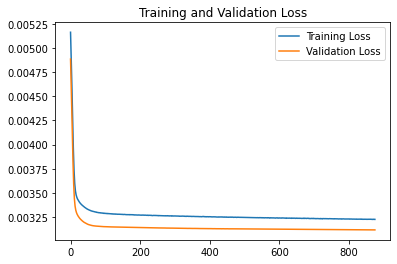

epoch: 875 Train loss: 0.0032250779768091906 time: 1.6483702659606934
epoch: 875 Eval loss: 0.003117346204817295 time: 1.554490089416504
epoch: 876 Train loss: 0.003226359398450543 time: 1.7057781219482422
epoch: 876 Eval loss: 0.0031175275798887014 time: 1.5273666381835938
epoch: 877 Train loss: 0.0032260649473335487 time: 1.6863453388214111
epoch: 877 Eval loss: 0.003117217216640711 time: 1.5468366146087646
epoch: 878 Train loss: 0.003226608455128974 time: 1.7662444114685059
epoch: 878 Eval loss: 0.003117084503173828 time: 1.558840036392212
epoch: 879 Train loss: 0.0032257519838378187 time: 1.7190189361572266
epoch: 879 Eval loss: 0.0031173303723335266 time: 1.5573055744171143
epoch: 880 Train loss: 0.003225027915165285 time: 1.6417274475097656
epoch: 880 Eval loss: 0.003116894280537963 time: 1.51350998878479
epoch: 881 Train loss: 0.0032265185266863537 time: 1.6719443798065186
epoch: 881 Eval loss: 0.003117046318948269 time: 1.5315048694610596
epoch: 882 Train loss: 0.00322656955305

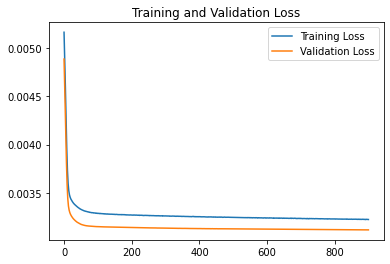

epoch: 900 Train loss: 0.003225018971861191 time: 1.776902437210083
epoch: 900 Eval loss: 0.0031168204732239246 time: 1.5625922679901123
epoch: 901 Train loss: 0.0032256379110815227 time: 1.7805259227752686
epoch: 901 Eval loss: 0.0031166989356279373 time: 1.61991286277771
epoch: 902 Train loss: 0.0032257716956101065 time: 1.7625596523284912
epoch: 902 Eval loss: 0.0031166463159024715 time: 1.661548137664795
epoch: 903 Train loss: 0.0032251553637670616 time: 1.7718393802642822
epoch: 903 Eval loss: 0.003117178101092577 time: 1.5779173374176025
epoch: 904 Train loss: 0.0032245638802295595 time: 1.740110158920288
epoch: 904 Eval loss: 0.003116114065051079 time: 1.6122431755065918
epoch: 905 Train loss: 0.003224462896507243 time: 1.702702522277832
epoch: 905 Eval loss: 0.003116762265563011 time: 1.5800762176513672
epoch: 906 Train loss: 0.003224746109828131 time: 1.8008956909179688
epoch: 906 Eval loss: 0.0031165420077741146 time: 1.648622989654541
epoch: 907 Train loss: 0.003224939551149

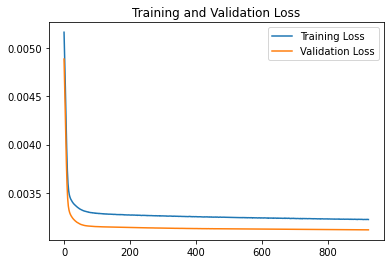

epoch: 925 Train loss: 0.003224604190282413 time: 1.821906566619873
epoch: 925 Eval loss: 0.0031161713413894176 time: 1.6378681659698486
epoch: 926 Train loss: 0.0032236544791794824 time: 1.8203370571136475
epoch: 926 Eval loss: 0.0031162933446466923 time: 1.6598033905029297
epoch: 927 Train loss: 0.0032224626470217033 time: 1.7852556705474854
epoch: 927 Eval loss: 0.0031162553932517767 time: 1.6544206142425537
epoch: 928 Train loss: 0.003223170836766561 time: 1.7582118511199951
epoch: 928 Eval loss: 0.003116084262728691 time: 1.7753469944000244
epoch: 929 Train loss: 0.0032235583191051465 time: 1.8090753555297852
epoch: 929 Eval loss: 0.0031160020735114813 time: 1.6285386085510254
epoch: 930 Train loss: 0.003224209902689109 time: 1.7727446556091309
epoch: 930 Eval loss: 0.003116009756922722 time: 1.6272180080413818
epoch: 931 Train loss: 0.003223609293331103 time: 1.8331756591796875
epoch: 931 Eval loss: 0.003115537576377392 time: 1.6138756275177002
epoch: 932 Train loss: 0.0032240985

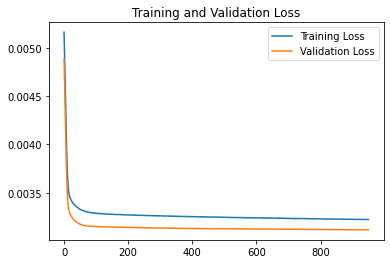

epoch: 950 Train loss: 0.0032234933171893876 time: 1.8001792430877686
epoch: 950 Eval loss: 0.003116641193628311 time: 1.5989999771118164
epoch: 951 Train loss: 0.0032234015896564394 time: 1.8161993026733398
epoch: 951 Eval loss: 0.003116756211966276 time: 1.6192736625671387
epoch: 952 Train loss: 0.0032231169683518165 time: 1.8304355144500732
epoch: 952 Eval loss: 0.003116182517260313 time: 1.6754324436187744
epoch: 953 Train loss: 0.0032225189142235516 time: 1.785848617553711
epoch: 953 Eval loss: 0.0031164418905973434 time: 1.6501710414886475
epoch: 954 Train loss: 0.003223245798863555 time: 1.784290075302124
epoch: 954 Eval loss: 0.0031155028846114874 time: 1.6363415718078613
epoch: 955 Train loss: 0.0032226249301840313 time: 1.846625566482544
epoch: 955 Eval loss: 0.003116579493507743 time: 1.6887412071228027
epoch: 956 Train loss: 0.003222192861693842 time: 1.794177770614624
epoch: 956 Eval loss: 0.0031157336197793484 time: 1.6544029712677002
epoch: 957 Train loss: 0.003222949887

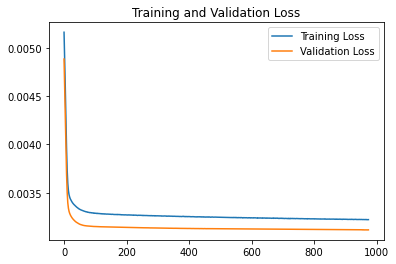

epoch: 975 Train loss: 0.003222039052507696 time: 1.7917449474334717
epoch: 975 Eval loss: 0.003116294275969267 time: 1.6455576419830322
epoch: 976 Train loss: 0.003221998325274477 time: 1.8567748069763184
epoch: 976 Eval loss: 0.003115494502708316 time: 1.6855039596557617
epoch: 977 Train loss: 0.0032226253212906245 time: 1.7953460216522217
epoch: 977 Eval loss: 0.003114705439656973 time: 1.6753911972045898
epoch: 978 Train loss: 0.003221989199453973 time: 1.7979710102081299
epoch: 978 Eval loss: 0.003115418367087841 time: 1.693697452545166
epoch: 979 Train loss: 0.003222244227026391 time: 1.8270518779754639
epoch: 979 Eval loss: 0.003115930361673236 time: 1.6960394382476807
epoch: 980 Train loss: 0.003222897844364637 time: 1.8348546028137207
epoch: 980 Eval loss: 0.003115074709057808 time: 1.687875747680664
epoch: 981 Train loss: 0.003221377743406454 time: 1.8564553260803223
epoch: 981 Eval loss: 0.0031152439769357443 time: 1.6418721675872803
epoch: 982 Train loss: 0.0032210528641965

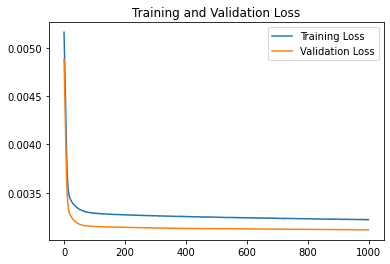

epoch: 1000 Train loss: 0.003220621656140839 time: 1.7873814105987549
epoch: 1000 Eval loss: 0.0031150381546467543 time: 1.6935734748840332
epoch: 1001 Train loss: 0.0032207427427420362 time: 1.7989025115966797
epoch: 1001 Eval loss: 0.003115857020020485 time: 1.6616196632385254
epoch: 1002 Train loss: 0.0032203964048170353 time: 1.8487074375152588
epoch: 1002 Eval loss: 0.0031142430379986763 time: 1.6767044067382812
epoch: 1003 Train loss: 0.003221482612120928 time: 1.8384878635406494
epoch: 1003 Eval loss: 0.0031147561967372894 time: 1.687622308731079
epoch: 1004 Train loss: 0.0032212124878340195 time: 1.8220009803771973
epoch: 1004 Eval loss: 0.003115127794444561 time: 1.6831302642822266
epoch: 1005 Train loss: 0.003220125446169395 time: 1.8726272583007812
epoch: 1005 Eval loss: 0.0031145894899964333 time: 1.7075939178466797
epoch: 1006 Train loss: 0.0032197980117297234 time: 1.8362817764282227
epoch: 1006 Eval loss: 0.003114961553364992 time: 1.7480487823486328
epoch: 1007 Train lo

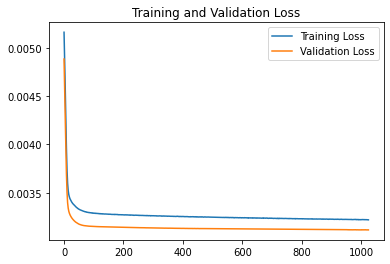

epoch: 1025 Train loss: 0.0032200391159074304 time: 2.5412933826446533
epoch: 1025 Eval loss: 0.003114271443337202 time: 1.9828810691833496
epoch: 1026 Train loss: 0.0032198735995972666 time: 3.4467153549194336
epoch: 1026 Eval loss: 0.0031144293025135994 time: 1.6674537658691406
epoch: 1027 Train loss: 0.0032201416901298918 time: 1.8592720031738281
epoch: 1027 Eval loss: 0.003114789491519332 time: 1.7162516117095947
epoch: 1028 Train loss: 0.0032193729310106625 time: 1.8754940032958984
epoch: 1028 Eval loss: 0.003114433493465185 time: 1.7502610683441162
epoch: 1029 Train loss: 0.0032199918441572213 time: 1.8777682781219482
epoch: 1029 Eval loss: 0.0031139503698796034 time: 1.8676831722259521
epoch: 1030 Train loss: 0.0032191001211251485 time: 1.8738853931427002
epoch: 1030 Eval loss: 0.0031143520027399063 time: 1.6684677600860596
epoch: 1031 Train loss: 0.0032202892676843225 time: 1.827284812927246
epoch: 1031 Eval loss: 0.003115200437605381 time: 1.6778428554534912
epoch: 1032 Train 

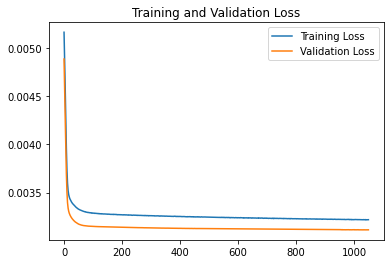

epoch: 1050 Train loss: 0.003219497902604017 time: 1.8621678352355957
epoch: 1050 Eval loss: 0.003114554798230529 time: 1.6981573104858398
epoch: 1051 Train loss: 0.003218700410187088 time: 1.878913402557373
epoch: 1051 Eval loss: 0.0031141280196607113 time: 1.7612004280090332
epoch: 1052 Train loss: 0.0032186726416189838 time: 1.975799322128296
epoch: 1052 Eval loss: 0.003114011138677597 time: 1.7575066089630127
epoch: 1053 Train loss: 0.0032188291885512812 time: 1.924070119857788
epoch: 1053 Eval loss: 0.0031137827318161726 time: 1.7035243511199951
epoch: 1054 Train loss: 0.003218845615028188 time: 1.874443531036377
epoch: 1054 Eval loss: 0.0031141312792897224 time: 1.7130701541900635
epoch: 1055 Train loss: 0.003219585197595578 time: 1.874288558959961
epoch: 1055 Eval loss: 0.0031145592220127583 time: 1.6974458694458008
epoch: 1056 Train loss: 0.0032186600479866888 time: 1.8481338024139404
epoch: 1056 Eval loss: 0.003114005085080862 time: 1.6819052696228027
epoch: 1057 Train loss: 0

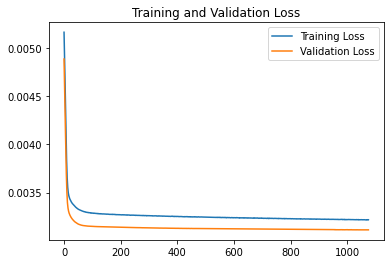

epoch: 1075 Train loss: 0.003217849622978417 time: 1.907987117767334
epoch: 1075 Eval loss: 0.003113754093647003 time: 1.7660918235778809
epoch: 1076 Train loss: 0.0032191486704902282 time: 1.9043498039245605
epoch: 1076 Eval loss: 0.0031145457178354263 time: 1.7460646629333496
epoch: 1077 Train loss: 0.003218441758360241 time: 1.9284327030181885
epoch: 1077 Eval loss: 0.003114166436716914 time: 1.7722680568695068
epoch: 1078 Train loss: 0.003218098653583076 time: 1.9709641933441162
epoch: 1078 Eval loss: 0.0031135741155594587 time: 1.7633776664733887
epoch: 1079 Train loss: 0.0032179622877509784 time: 2.090111017227173
epoch: 1079 Eval loss: 0.0031134109012782574 time: 1.8810055255889893
epoch: 1080 Train loss: 0.0032167923054148622 time: 1.9158697128295898
epoch: 1080 Eval loss: 0.003113921731710434 time: 1.7431576251983643
epoch: 1081 Train loss: 0.0032179700055877474 time: 1.9486150741577148
epoch: 1081 Eval loss: 0.0031140269711613655 time: 1.7186541557312012
epoch: 1082 Train los

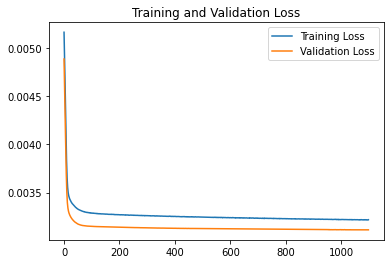

epoch: 1100 Train loss: 0.003217787854210494 time: 1.9409971237182617
epoch: 1100 Eval loss: 0.0031137901823967695 time: 1.8206589221954346
epoch: 1101 Train loss: 0.003216868258315226 time: 2.0060155391693115
epoch: 1101 Eval loss: 0.003113304264843464 time: 1.7797534465789795
epoch: 1102 Train loss: 0.0032173209511597535 time: 1.9525730609893799
epoch: 1102 Eval loss: 0.0031139981001615524 time: 1.7968735694885254
epoch: 1103 Train loss: 0.0032177165163679283 time: 1.9054687023162842
epoch: 1103 Eval loss: 0.003114644205197692 time: 1.783935785293579
epoch: 1104 Train loss: 0.003217297928018311 time: 1.9345014095306396
epoch: 1104 Eval loss: 0.0031144344247877598 time: 1.7928361892700195
epoch: 1105 Train loss: 0.003217368692237874 time: 1.9149713516235352
epoch: 1105 Eval loss: 0.003113849088549614 time: 1.8524649143218994
epoch: 1106 Train loss: 0.003217905811958947 time: 2.0251970291137695
epoch: 1106 Eval loss: 0.003112909384071827 time: 1.8319377899169922
epoch: 1107 Train loss:

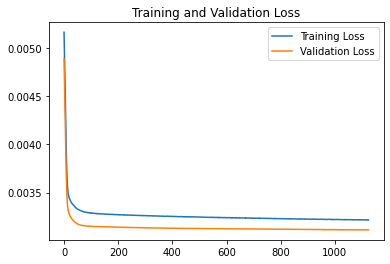

epoch: 1125 Train loss: 0.0032162232974695722 time: 2.0133938789367676
epoch: 1125 Eval loss: 0.003113590180873871 time: 1.8006069660186768
epoch: 1126 Train loss: 0.003217123650920464 time: 1.963663101196289
epoch: 1126 Eval loss: 0.0031132488511502743 time: 1.7855134010314941
epoch: 1127 Train loss: 0.0032167532990506524 time: 2.147355556488037
epoch: 1127 Eval loss: 0.003113056533038616 time: 1.930372953414917
epoch: 1128 Train loss: 0.0032164985061421897 time: 1.9665954113006592
epoch: 1128 Eval loss: 0.0031132781878113747 time: 1.8203222751617432
epoch: 1129 Train loss: 0.0032153735010642705 time: 1.9706897735595703
epoch: 1129 Eval loss: 0.0031137007754296064 time: 1.7988510131835938
epoch: 1130 Train loss: 0.0032163480604727435 time: 1.9684579372406006
epoch: 1130 Eval loss: 0.0031128772534430027 time: 1.791039228439331
epoch: 1131 Train loss: 0.0032162635814486527 time: 1.9534111022949219
epoch: 1131 Eval loss: 0.0031133978627622128 time: 1.8507726192474365
epoch: 1132 Train lo

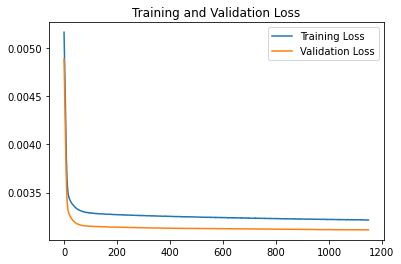

epoch: 1150 Train loss: 0.003214721057045804 time: 1.9728553295135498
epoch: 1150 Eval loss: 0.003112844657152891 time: 1.8440666198730469
epoch: 1151 Train loss: 0.0032163807830576925 time: 2.052432060241699
epoch: 1151 Eval loss: 0.0031133496668189764 time: 1.813704490661621
epoch: 1152 Train loss: 0.0032156547849259663 time: 1.9857215881347656
epoch: 1152 Eval loss: 0.0031133764423429966 time: 1.813107967376709
epoch: 1153 Train loss: 0.003216135272412371 time: 1.9711713790893555
epoch: 1153 Eval loss: 0.003113575279712677 time: 1.864030361175537
epoch: 1154 Train loss: 0.0032157544388858664 time: 1.9911680221557617
epoch: 1154 Eval loss: 0.003112663049250841 time: 1.766965627670288
epoch: 1155 Train loss: 0.003215708653340711 time: 1.974839687347412
epoch: 1155 Eval loss: 0.0031138192862272263 time: 1.814711093902588
epoch: 1156 Train loss: 0.0032152322855104193 time: 2.017747640609741
epoch: 1156 Eval loss: 0.003113031154498458 time: 1.8334686756134033
epoch: 1157 Train loss: 0.00

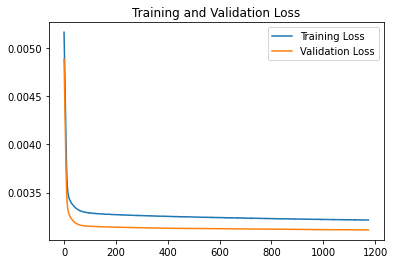

epoch: 1175 Train loss: 0.0032137942126416784 time: 1.9718635082244873
epoch: 1175 Eval loss: 0.003112640930339694 time: 1.8480932712554932
epoch: 1176 Train loss: 0.003213930656695095 time: 2.0884923934936523
epoch: 1176 Eval loss: 0.003112418344244361 time: 1.8510258197784424
epoch: 1177 Train loss: 0.003215718717817038 time: 1.9972031116485596
epoch: 1177 Eval loss: 0.0031129862181842327 time: 1.8367295265197754
epoch: 1178 Train loss: 0.0032144345845033073 time: 2.0138931274414062
epoch: 1178 Eval loss: 0.0031131450086832047 time: 1.872166633605957
epoch: 1179 Train loss: 0.003213876214657347 time: 2.0609781742095947
epoch: 1179 Eval loss: 0.0031132891308516264 time: 1.8682255744934082
epoch: 1180 Train loss: 0.003214911525956602 time: 2.085322618484497
epoch: 1180 Eval loss: 0.003113156883046031 time: 1.8347818851470947
epoch: 1181 Train loss: 0.003213432047936547 time: 2.0197181701660156
epoch: 1181 Eval loss: 0.003113165032118559 time: 1.8364222049713135
epoch: 1182 Train loss: 

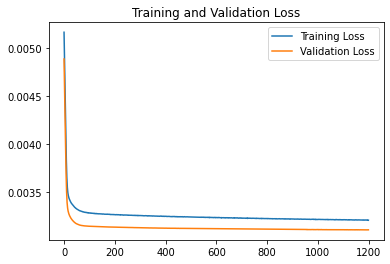

epoch: 1200 Train loss: 0.0032136917687880817 time: 2.038878917694092
epoch: 1200 Eval loss: 0.0031129182316362858 time: 1.878549337387085
epoch: 1201 Train loss: 0.0032137321570622534 time: 2.0669443607330322
epoch: 1201 Eval loss: 0.0031127422116696835 time: 1.879138708114624
epoch: 1202 Train loss: 0.003213603274402969 time: 2.07487154006958
epoch: 1202 Eval loss: 0.0031121703796088696 time: 1.8677494525909424
epoch: 1203 Train loss: 0.0032133713481933114 time: 2.054887056350708
epoch: 1203 Eval loss: 0.0031120902858674526 time: 1.8498082160949707
epoch: 1204 Train loss: 0.0032139357671545766 time: 2.0739476680755615
epoch: 1204 Eval loss: 0.0031127273105084896 time: 1.8476779460906982
epoch: 1205 Train loss: 0.0032152318422562806 time: 2.0805304050445557
epoch: 1205 Eval loss: 0.0031140195205807686 time: 1.8640778064727783
epoch: 1206 Train loss: 0.003213216991457935 time: 2.104086399078369
epoch: 1206 Eval loss: 0.0031134882010519505 time: 1.8894703388214111
epoch: 1207 Train loss

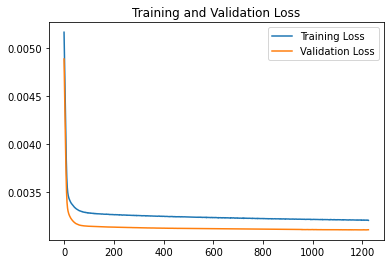

epoch: 1225 Train loss: 0.003213027304760323 time: 2.102964401245117
epoch: 1225 Eval loss: 0.003112273756414652 time: 1.9782097339630127
epoch: 1226 Train loss: 0.0032140557065097677 time: 2.123396873474121
epoch: 1226 Eval loss: 0.003112648380920291 time: 1.9883253574371338
epoch: 1227 Train loss: 0.00321227632795419 time: 2.1716532707214355
epoch: 1227 Eval loss: 0.0031131673604249954 time: 1.9926142692565918
epoch: 1228 Train loss: 0.003213176003486987 time: 2.1795477867126465
epoch: 1228 Eval loss: 0.0031129892449826 time: 1.9213738441467285
epoch: 1229 Train loss: 0.003213692524927495 time: 2.0863399505615234
epoch: 1229 Eval loss: 0.0031123291701078415 time: 1.9562373161315918
epoch: 1230 Train loss: 0.0032122249104740946 time: 2.1579716205596924
epoch: 1230 Eval loss: 0.003112803678959608 time: 1.9444234371185303
epoch: 1231 Train loss: 0.003213104483128011 time: 2.0984373092651367
epoch: 1231 Eval loss: 0.0031119431369006634 time: 1.9916939735412598
epoch: 1232 Train loss: 0.0

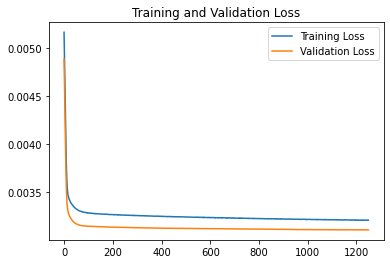

epoch: 1250 Train loss: 0.003212981597436486 time: 2.1554980278015137
epoch: 1250 Eval loss: 0.003112292382866144 time: 1.9204013347625732
epoch: 1251 Train loss: 0.0032116628120786145 time: 2.1617352962493896
epoch: 1251 Eval loss: 0.0031125997193157673 time: 1.9396352767944336
epoch: 1252 Train loss: 0.003212554952291053 time: 2.1478042602539062
epoch: 1252 Eval loss: 0.003112326143309474 time: 1.9368984699249268
epoch: 1253 Train loss: 0.003212206372021586 time: 2.112039804458618
epoch: 1253 Eval loss: 0.0031126278918236494 time: 1.9688172340393066
epoch: 1254 Train loss: 0.003212590647286109 time: 2.1577086448669434
epoch: 1254 Eval loss: 0.003112648380920291 time: 1.9850842952728271
epoch: 1255 Train loss: 0.0032120951673803052 time: 2.20628023147583
epoch: 1255 Eval loss: 0.0031116751488298178 time: 1.975766658782959
epoch: 1256 Train loss: 0.003212428520566418 time: 2.2397730350494385
epoch: 1256 Eval loss: 0.0031117626931518316 time: 2.0281765460968018
epoch: 1257 Train loss: 0

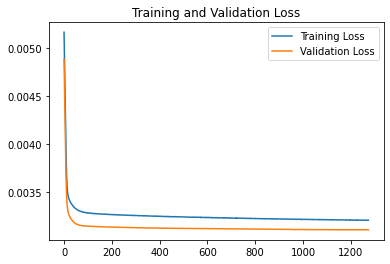

epoch: 1275 Train loss: 0.0032118436076196788 time: 2.1426291465759277
epoch: 1275 Eval loss: 0.0031115624587982893 time: 1.9928946495056152
epoch: 1276 Train loss: 0.0032106001754653945 time: 2.1995909214019775
epoch: 1276 Eval loss: 0.003112498437985778 time: 2.027106285095215
epoch: 1277 Train loss: 0.003210706817196423 time: 2.2199501991271973
epoch: 1277 Eval loss: 0.003112783655524254 time: 2.001774787902832
epoch: 1278 Train loss: 0.0032128445536862937 time: 2.209324598312378
epoch: 1278 Eval loss: 0.0031118160113692284 time: 2.0129876136779785
epoch: 1279 Train loss: 0.0032126651661289647 time: 2.1795907020568848
epoch: 1279 Eval loss: 0.003113079583272338 time: 2.0463781356811523
epoch: 1280 Train loss: 0.0032121489575737314 time: 2.1499950885772705
epoch: 1280 Eval loss: 0.0031123484950512648 time: 2.0112881660461426
epoch: 1281 Train loss: 0.0032123096502359146 time: 2.207761526107788
epoch: 1281 Eval loss: 0.0031121778301894665 time: 2.0398476123809814
epoch: 1282 Train los

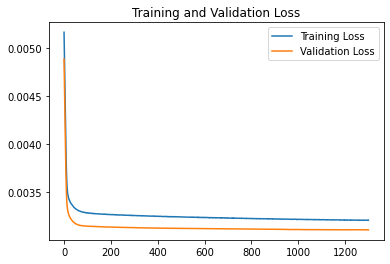

epoch: 1300 Train loss: 0.0032121207196777156 time: 2.201665163040161
epoch: 1300 Eval loss: 0.0031125005334615707 time: 2.023137331008911
epoch: 1301 Train loss: 0.0032127254747656075 time: 2.2177176475524902
epoch: 1301 Eval loss: 0.003111833706498146 time: 1.9927403926849365
epoch: 1302 Train loss: 0.0032120456793594027 time: 2.2298831939697266
epoch: 1302 Eval loss: 0.003111855126917362 time: 2.061152935028076
epoch: 1303 Train loss: 0.0032110072652811765 time: 2.2687747478485107
epoch: 1303 Eval loss: 0.003112028818577528 time: 1.9936692714691162
epoch: 1304 Train loss: 0.003211196456577104 time: 2.156073808670044
epoch: 1304 Eval loss: 0.003111919853836298 time: 2.052973508834839
epoch: 1305 Train loss: 0.0032106328719765705 time: 2.253347396850586
epoch: 1305 Eval loss: 0.003112014150246978 time: 2.0439231395721436
epoch: 1306 Train loss: 0.003212143690671612 time: 2.2008912563323975
epoch: 1306 Eval loss: 0.003112281672656536 time: 2.019024133682251
epoch: 1307 Train loss: 0.00

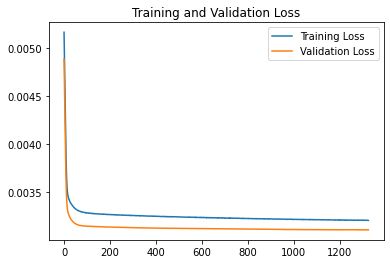

epoch: 1325 Train loss: 0.0032108083484679696 time: 2.359227180480957
epoch: 1325 Eval loss: 0.0031128886621445417 time: 2.072925329208374
epoch: 1326 Train loss: 0.003212047947777642 time: 2.304126024246216
epoch: 1326 Eval loss: 0.0031111352145671844 time: 2.1004977226257324
epoch: 1327 Train loss: 0.003211698168114623 time: 2.3283073902130127
epoch: 1327 Eval loss: 0.0031115314923226833 time: 2.1700713634490967
epoch: 1328 Train loss: 0.00321076034665212 time: 2.2944233417510986
epoch: 1328 Eval loss: 0.0031126549001783133 time: 2.11580228805542
epoch: 1329 Train loss: 0.003210576787291132 time: 2.2818148136138916
epoch: 1329 Eval loss: 0.00311186327598989 time: 2.10685396194458
epoch: 1330 Train loss: 0.0032099237957234354 time: 2.4010109901428223
epoch: 1330 Eval loss: 0.0031117689795792103 time: 2.1041831970214844
epoch: 1331 Train loss: 0.003209841715486448 time: 2.292930841445923
epoch: 1331 Eval loss: 0.003111855126917362 time: 2.088517189025879
epoch: 1332 Train loss: 0.00321

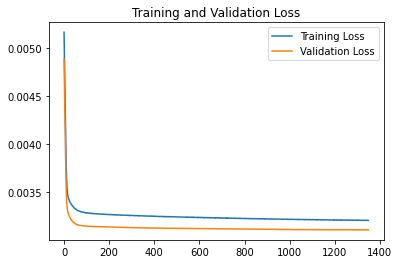

epoch: 1350 Train loss: 0.003211205582397608 time: 2.2749266624450684
epoch: 1350 Eval loss: 0.0031115205492824316 time: 2.0806615352630615
epoch: 1351 Train loss: 0.0032108544208246264 time: 2.288607358932495
epoch: 1351 Eval loss: 0.0031128092668950558 time: 2.073173761367798
epoch: 1352 Train loss: 0.0032112787193305015 time: 2.289632797241211
epoch: 1352 Eval loss: 0.003113123355433345 time: 2.0769526958465576
epoch: 1353 Train loss: 0.0032105454205423726 time: 2.204257011413574
epoch: 1353 Eval loss: 0.0031122989021241665 time: 2.1621603965759277
epoch: 1354 Train loss: 0.0032093538751960947 time: 2.281773567199707
epoch: 1354 Eval loss: 0.0031112905126065016 time: 2.0761818885803223
epoch: 1355 Train loss: 0.003209206062977708 time: 2.28474497795105
epoch: 1355 Eval loss: 0.003111714031547308 time: 2.1270105838775635
epoch: 1356 Train loss: 0.003210474213068671 time: 2.3003695011138916
epoch: 1356 Eval loss: 0.003112210426479578 time: 2.0742902755737305
epoch: 1357 Train loss: 0.

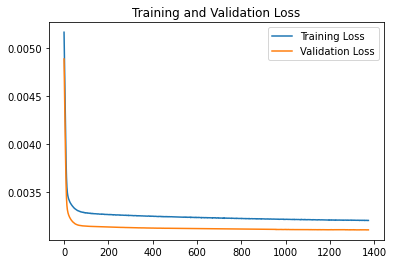

epoch: 1375 Train loss: 0.003209177955450557 time: 2.4098453521728516
epoch: 1375 Eval loss: 0.0031116334721446037 time: 2.263972520828247
epoch: 1376 Train loss: 0.003210302856233385 time: 2.286865711212158
epoch: 1376 Eval loss: 0.0031115817837417126 time: 2.151038646697998
epoch: 1377 Train loss: 0.0032097608867905584 time: 2.3345565795898438
epoch: 1377 Eval loss: 0.00311221438460052 time: 2.1421597003936768
epoch: 1378 Train loss: 0.0032074706708769577 time: 2.3612873554229736
epoch: 1378 Eval loss: 0.003111278172582388 time: 2.1057775020599365
epoch: 1379 Train loss: 0.0032093585163276653 time: 2.2783918380737305
epoch: 1379 Eval loss: 0.003112270962446928 time: 2.1185989379882812
epoch: 1380 Train loss: 0.003208391492239551 time: 2.271954298019409
epoch: 1380 Eval loss: 0.003112038131803274 time: 2.076864242553711
epoch: 1381 Train loss: 0.0032094498527540207 time: 2.2996366024017334
epoch: 1381 Eval loss: 0.003112287726253271 time: 2.1113150119781494
epoch: 1382 Train loss: 0.0

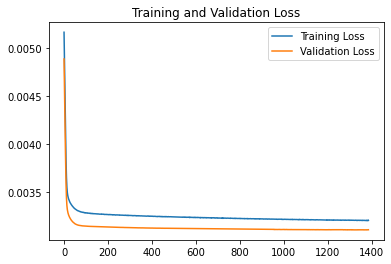

In [ ]:
av.lr=[0.0005] #best Lr for this model
for lr in av.lr:
  av.LEARNING_RATE=lr
  av.model_name="Feedforward"
  run(fold, train_loader, val_loader, test_loader, tr_sz, test_sz, val_sz,model=Feedforward(av))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 Train loss: 0.00493989179557807 time: 2.8855462074279785
epoch: 0 Eval loss: 0.004588468465954065 time: 2.5264828205108643
epoch: 1 Train loss: 0.004660133353889979 time: 2.781165838241577
epoch: 1 Eval loss: 0.0042839436791837215 time: 2.5364010334014893
epoch: 2 Train loss: 0.0043546957398128425 time: 2.6849000453948975
epoch: 2 Eval loss: 0.003980802837759256 time: 2.552283525466919
epoch: 3 Train loss: 0.004070078711288599 time: 3.0343263149261475
epoch: 3 Eval loss: 0.0037443973124027252 time: 2.5058438777923584
epoch: 4 Train loss: 0.0038490956641036174 time: 2.768648147583008
epoch: 4 Eval loss: 0.0035691442899405956 time: 2.506984233856201
epoch: 5 Train loss: 0.0036837290956175128 time: 2.683450698852539
epoch: 5 Eval loss: 0.0034413866233080626 time: 2.53528094291687
epoch: 6 Train loss: 0.003564147263999999 time: 2.8380331993103027
epoch: 6 Eval loss: 0.0033530413638800383 time: 2.7429347038269043
epoch: 7 Train loss: 0.0034794518536678657 time: 2.819565773010254
ep

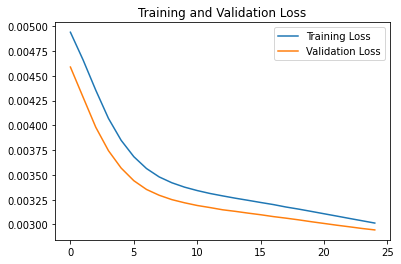

epoch: 25 Train loss: 0.0029916455113668766 time: 2.9800782203674316
epoch: 25 Eval loss: 0.002929104957729578 time: 2.5472159385681152
epoch: 26 Train loss: 0.002970966271736699 time: 2.738246440887451
epoch: 26 Eval loss: 0.002915309276431799 time: 2.491337537765503
epoch: 27 Train loss: 0.0029499465086328704 time: 2.7715561389923096
epoch: 27 Eval loss: 0.0029026768170297146 time: 2.548633098602295
epoch: 28 Train loss: 0.0029305717398592597 time: 2.715045213699341
epoch: 28 Eval loss: 0.002890364732593298 time: 2.543583393096924
epoch: 29 Train loss: 0.002912741294578826 time: 2.8290271759033203
epoch: 29 Eval loss: 0.0028786049224436283 time: 2.5217208862304688
epoch: 30 Train loss: 0.0028933322909414404 time: 2.8236889839172363
epoch: 30 Eval loss: 0.002868096111342311 time: 2.5283987522125244
epoch: 31 Train loss: 0.0028756198294832324 time: 2.7910702228546143
epoch: 31 Eval loss: 0.0028565851971507072 time: 2.4921481609344482
epoch: 32 Train loss: 0.002858540752115525 time: 2.7

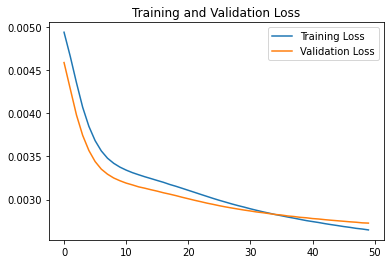

epoch: 50 Train loss: 0.0026399171467111075 time: 2.6866304874420166
epoch: 50 Eval loss: 0.002720888704061508 time: 2.503437042236328
epoch: 51 Train loss: 0.002630157446715254 time: 2.7683980464935303
epoch: 51 Eval loss: 0.0027150800451636314 time: 2.562169075012207
epoch: 52 Train loss: 0.0026223542444140683 time: 2.809861421585083
epoch: 52 Eval loss: 0.0027121570892632008 time: 2.605133533477783
epoch: 53 Train loss: 0.0026142532535529616 time: 2.751467704772949
epoch: 53 Eval loss: 0.002706235973164439 time: 2.528585195541382
epoch: 54 Train loss: 0.0026059885193982463 time: 2.7426064014434814
epoch: 54 Eval loss: 0.002702448982745409 time: 2.5858194828033447
epoch: 55 Train loss: 0.0025994719534929863 time: 2.7859997749328613
epoch: 55 Eval loss: 0.00269898260012269 time: 2.61024808883667
epoch: 56 Train loss: 0.002591014768820735 time: 2.961815118789673
epoch: 56 Eval loss: 0.0026937301736325026 time: 2.7299468517303467
epoch: 57 Train loss: 0.0025836380291485725 time: 3.01076

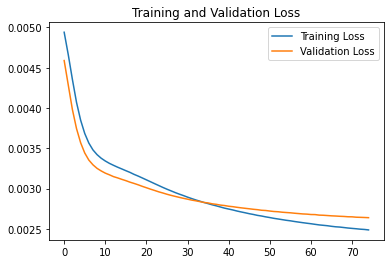

epoch: 75 Train loss: 0.0024825935288677065 time: 2.8183140754699707
epoch: 75 Eval loss: 0.0026356009766459465 time: 2.582451343536377
epoch: 76 Train loss: 0.0024777395831631238 time: 2.722602367401123
epoch: 76 Eval loss: 0.002634038683027029 time: 2.467663288116455
epoch: 77 Train loss: 0.0024734865075542755 time: 2.725898265838623
epoch: 77 Eval loss: 0.002632120158523321 time: 2.4951882362365723
epoch: 78 Train loss: 0.0024695155762416276 time: 2.824704170227051
epoch: 78 Eval loss: 0.002629646798595786 time: 2.5683364868164062
epoch: 79 Train loss: 0.002465220991186374 time: 2.839794874191284
epoch: 79 Eval loss: 0.0026281026657670736 time: 2.551664352416992
epoch: 80 Train loss: 0.0024613090908954982 time: 2.826646089553833
epoch: 80 Eval loss: 0.0026263496838510036 time: 2.7461650371551514
epoch: 81 Train loss: 0.0024578631549995403 time: 2.6886556148529053
epoch: 81 Eval loss: 0.0026230434887111187 time: 2.5265910625457764
epoch: 82 Train loss: 0.0024548718935548477 time: 2.7

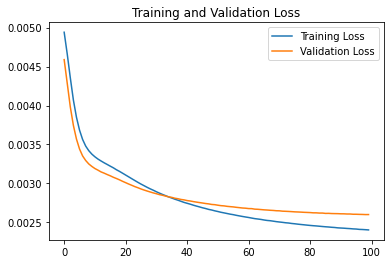

epoch: 100 Train loss: 0.0024003773432286915 time: 2.7835311889648438
epoch: 100 Eval loss: 0.0025999890640378 time: 2.550121307373047
epoch: 101 Train loss: 0.0023988563036146855 time: 2.7764811515808105
epoch: 101 Eval loss: 0.0025981550570577383 time: 2.567166805267334
epoch: 102 Train loss: 0.0023970509034337856 time: 2.8083112239837646
epoch: 102 Eval loss: 0.002597859827801585 time: 2.755094289779663
epoch: 103 Train loss: 0.002394190897361709 time: 2.9646003246307373
epoch: 103 Eval loss: 0.002597307087853551 time: 2.539088249206543
epoch: 104 Train loss: 0.002392146244240975 time: 2.7730767726898193
epoch: 104 Eval loss: 0.002595632104203105 time: 2.516280174255371
epoch: 105 Train loss: 0.0023897569740642505 time: 2.763115406036377
epoch: 105 Eval loss: 0.0025963736698031425 time: 2.5207619667053223
epoch: 106 Train loss: 0.002387810097591771 time: 2.7618865966796875
epoch: 106 Eval loss: 0.0025937154423445463 time: 2.5968189239501953
epoch: 107 Train loss: 0.00238594665719246

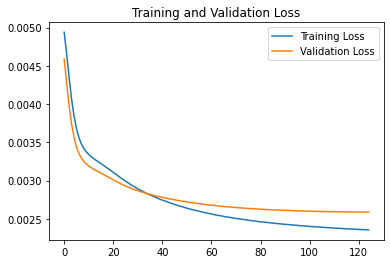

epoch: 125 Train loss: 0.0023539052234859918 time: 3.0250494480133057
epoch: 125 Eval loss: 0.0025870539247989655 time: 2.800191640853882
epoch: 126 Train loss: 0.00235329319381547 time: 2.723736047744751
epoch: 126 Eval loss: 0.002586388261988759 time: 2.581798791885376
epoch: 127 Train loss: 0.002351455488229987 time: 2.8240013122558594
epoch: 127 Eval loss: 0.0025869468227028847 time: 2.632767677307129
epoch: 128 Train loss: 0.0023481786146773024 time: 2.816303014755249
epoch: 128 Eval loss: 0.0025867708027362823 time: 2.5959506034851074
epoch: 129 Train loss: 0.002348167715840244 time: 2.8164687156677246
epoch: 129 Eval loss: 0.0025857677683234215 time: 2.6503517627716064
epoch: 130 Train loss: 0.002345675975736149 time: 2.839205741882324
epoch: 130 Eval loss: 0.00258623412810266 time: 2.633958578109741
epoch: 131 Train loss: 0.0023464228068123963 time: 2.8526623249053955
epoch: 131 Eval loss: 0.0025864490307867527 time: 2.6153955459594727
epoch: 132 Train loss: 0.00234327763188646

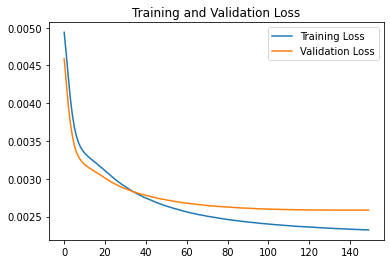

epoch: 150 Train loss: 0.00232374660299206 time: 2.753310441970825
epoch: 150 Eval loss: 0.0025860981550067663 time: 2.610177993774414
epoch: 151 Train loss: 0.0023220750394872896 time: 2.84893536567688
epoch: 151 Eval loss: 0.0025857959408313036 time: 2.7434632778167725
epoch: 152 Train loss: 0.0023213711519149555 time: 2.8715405464172363
epoch: 152 Eval loss: 0.0025873160921037197 time: 2.668224573135376
epoch: 153 Train loss: 0.00232041312327848 time: 2.7997829914093018
epoch: 153 Eval loss: 0.0025855291169136763 time: 2.6062686443328857
epoch: 154 Train loss: 0.0023192475734837518 time: 2.760915994644165
epoch: 154 Eval loss: 0.002586602233350277 time: 2.5761489868164062
epoch: 155 Train loss: 0.002318430890769992 time: 2.7597715854644775
epoch: 155 Eval loss: 0.0025856364518404007 time: 2.584277868270874
epoch: 156 Train loss: 0.0023177155307375955 time: 2.690185546875
epoch: 156 Eval loss: 0.0025869407691061497 time: 2.634873390197754
epoch: 157 Train loss: 0.002315947233535486 t

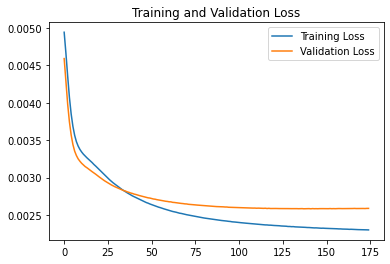

epoch: 175 Train loss: 0.002303081104240184 time: 2.82204532623291
epoch: 175 Eval loss: 0.0025895738508552313 time: 2.7153682708740234
epoch: 176 Train loss: 0.0023017950153934883 time: 2.9199981689453125
epoch: 176 Eval loss: 0.0025903303176164627 time: 2.660207986831665
epoch: 177 Train loss: 0.0023009552052431948 time: 2.9705352783203125
epoch: 177 Eval loss: 0.002590352902188897 time: 2.6341705322265625
epoch: 178 Train loss: 0.0022988150438924475 time: 2.7887823581695557
epoch: 178 Eval loss: 0.002589673735201359 time: 2.645939588546753
epoch: 179 Train loss: 0.0022997429051737146 time: 2.8528828620910645
epoch: 179 Eval loss: 0.002591499127447605 time: 2.6064865589141846
epoch: 180 Train loss: 0.00229941489711104 time: 3.088230848312378
epoch: 180 Eval loss: 0.0025903210043907166 time: 2.746774673461914
epoch: 181 Train loss: 0.0022969467016238448 time: 2.8722915649414062
epoch: 181 Eval loss: 0.0025905128568410873 time: 2.6492807865142822
epoch: 182 Train loss: 0.00229697376620

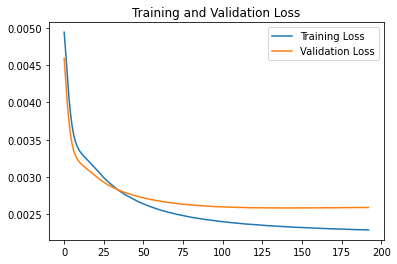

In [ ]:
av.lr=[0.0005] #best Lr for this model
for lr in av.lr:
  av.LEARNING_RATE=lr
  av.model_name="CNN1D"
  run(fold, train_loader, val_loader, test_loader, tr_sz, test_sz, val_sz,model=OpenVaccineCNN(av))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 Train loss: 0.004319771068302665 time: 2.3863823413848877
epoch: 0 Eval loss: 0.003710526507347822 time: 2.3007190227508545
epoch: 1 Train loss: 0.0037591070432154003 time: 2.5471062660217285
epoch: 1 Eval loss: 0.003432560246437788 time: 2.1507039070129395
epoch: 2 Train loss: 0.0035453034354632922 time: 2.3005940914154053
epoch: 2 Eval loss: 0.0032924495171755552 time: 2.099294900894165
epoch: 3 Train loss: 0.003399907890788735 time: 2.354830741882324
epoch: 3 Eval loss: 0.0032001608051359653 time: 2.1312978267669678
epoch: 4 Train loss: 0.0032976446241427177 time: 2.4319210052490234
epoch: 4 Eval loss: 0.00311894528567791 time: 2.165113925933838
epoch: 5 Train loss: 0.0032128661166964554 time: 2.421083927154541
epoch: 5 Eval loss: 0.0030583187472075224 time: 2.1216013431549072
epoch: 6 Train loss: 0.0031639001970216046 time: 2.3969030380249023
epoch: 6 Eval loss: 0.0030227943789213896 time: 2.114928722381592
epoch: 7 Train loss: 0.0031260194897338787 time: 2.399049997329712

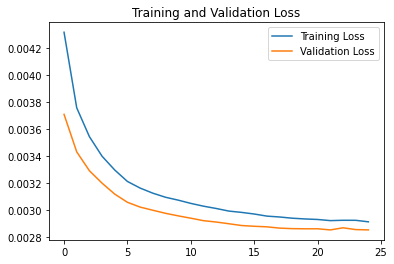

epoch: 25 Train loss: 0.0029055369025453182 time: 2.3846206665039062
epoch: 25 Eval loss: 0.002853041049093008 time: 2.139857292175293
epoch: 26 Train loss: 0.002899029697124518 time: 2.4424877166748047
epoch: 26 Eval loss: 0.0028504428919404745 time: 2.2213313579559326
epoch: 27 Train loss: 0.002894434064287735 time: 2.621248483657837
epoch: 27 Eval loss: 0.002852345583960414 time: 2.321425199508667
epoch: 28 Train loss: 0.0028908966094490112 time: 2.4181618690490723
epoch: 28 Eval loss: 0.0028445653151720762 time: 2.1304149627685547
epoch: 29 Train loss: 0.0028844431160003183 time: 2.4306678771972656
epoch: 29 Eval loss: 0.0028657549992203712 time: 2.194145679473877
epoch: 30 Train loss: 0.0028883143412055203 time: 2.4125943183898926
epoch: 30 Eval loss: 0.0028398865833878517 time: 2.172117233276367
epoch: 31 Train loss: 0.002874214974601125 time: 2.3514561653137207
epoch: 31 Eval loss: 0.0028481006156653166 time: 2.1543190479278564
epoch: 32 Train loss: 0.002875239595653504 time: 2.

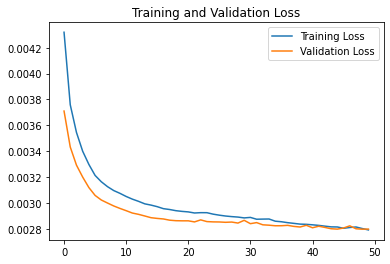

epoch: 50 Train loss: 0.0027849997278899348 time: 2.422698497772217
epoch: 50 Eval loss: 0.002788680139929056 time: 2.2105255126953125
epoch: 51 Train loss: 0.0027789875851945717 time: 2.4991819858551025
epoch: 51 Eval loss: 0.0027864468283951283 time: 2.1459803581237793
epoch: 52 Train loss: 0.0027750608228531617 time: 2.4252121448516846
epoch: 52 Eval loss: 0.0027933891396969557 time: 2.151254177093506
epoch: 53 Train loss: 0.0027714750533133145 time: 2.475123882293701
epoch: 53 Eval loss: 0.0027852633502334356 time: 2.195331335067749
epoch: 54 Train loss: 0.0027698965471039086 time: 2.6088500022888184
epoch: 54 Eval loss: 0.002788536250591278 time: 2.186889410018921
epoch: 55 Train loss: 0.002767652194956782 time: 2.4969518184661865
epoch: 55 Eval loss: 0.002777479123324156 time: 2.199913501739502
epoch: 56 Train loss: 0.0027596049682153284 time: 2.41166090965271
epoch: 56 Eval loss: 0.002784598618745804 time: 2.194403886795044
epoch: 57 Train loss: 0.002758655987178038 time: 2.4539

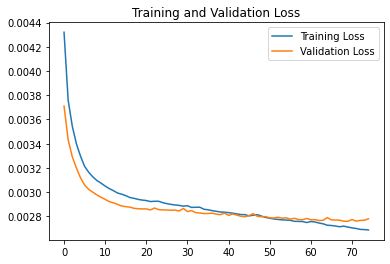

epoch: 75 Train loss: 0.002693056486618696 time: 2.388697385787964
epoch: 75 Eval loss: 0.0027485881000757217 time: 2.1733343601226807
epoch: 76 Train loss: 0.002682544349685429 time: 2.4753711223602295
epoch: 76 Eval loss: 0.002761371899396181 time: 2.2231149673461914
epoch: 77 Train loss: 0.0026742983364996323 time: 2.467801809310913
epoch: 77 Eval loss: 0.002769703511148691 time: 2.13775634765625
epoch: 78 Train loss: 0.0026717036049927105 time: 2.482542037963867
epoch: 78 Eval loss: 0.0027702203951776028 time: 2.158661365509033
epoch: 79 Train loss: 0.002671092566125558 time: 2.5066983699798584
epoch: 79 Eval loss: 0.0027424930594861507 time: 2.3445422649383545
epoch: 80 Train loss: 0.0026690709100724934 time: 2.4303276538848877
epoch: 80 Eval loss: 0.0027704467065632343 time: 2.1350350379943848
epoch: 81 Train loss: 0.0026623192630310594 time: 2.424903392791748
epoch: 81 Eval loss: 0.0027562312316149473 time: 2.149991035461426
epoch: 82 Train loss: 0.002655022543767827 time: 2.415

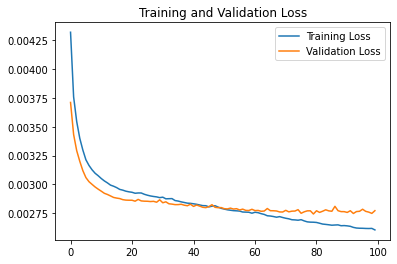

epoch: 100 Train loss: 0.0025961603236010693 time: 2.5037477016448975
epoch: 100 Eval loss: 0.0027548368088901043 time: 2.2343966960906982
epoch: 101 Train loss: 0.0025933383070160607 time: 2.3962836265563965
epoch: 101 Eval loss: 0.002759690163657069 time: 2.184114456176758
epoch: 102 Train loss: 0.002595549780135601 time: 2.4765663146972656
epoch: 102 Eval loss: 0.0027659644838422537 time: 2.1421873569488525
epoch: 103 Train loss: 0.002597772960379159 time: 2.4401497840881348
epoch: 103 Eval loss: 0.002752030035480857 time: 2.198892593383789
epoch: 104 Train loss: 0.002587539812815575 time: 2.4194436073303223
epoch: 104 Eval loss: 0.0027649318799376488 time: 2.222388982772827
epoch: 105 Train loss: 0.0025909855140475776 time: 2.4892404079437256
epoch: 105 Eval loss: 0.0027412367053329945 time: 2.521592855453491
epoch: 106 Train loss: 0.0025901180656980444 time: 2.462435722351074
epoch: 106 Eval loss: 0.002739597810432315 time: 2.1766350269317627
epoch: 107 Train loss: 0.0025888011315

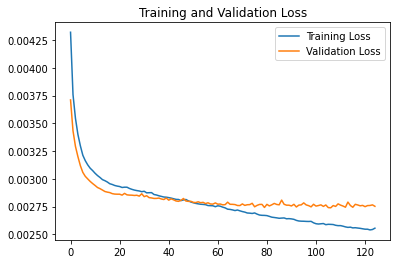

epoch: 125 Train loss: 0.002544484452416995 time: 2.5134403705596924
epoch: 125 Eval loss: 0.0027729140128940344 time: 2.3652451038360596
epoch: 126 Train loss: 0.0025409776342613906 time: 2.6390042304992676
epoch: 126 Eval loss: 0.002760285511612892 time: 2.3303797245025635
epoch: 127 Train loss: 0.002541305929135567 time: 2.6668264865875244
epoch: 127 Eval loss: 0.002745460718870163 time: 2.300816535949707
epoch: 128 Train loss: 0.0025367879961419293 time: 2.574856996536255
epoch: 128 Eval loss: 0.002747985301539302 time: 2.3032455444335938
epoch: 129 Train loss: 0.0025287208751117777 time: 2.4905006885528564
epoch: 129 Eval loss: 0.002763313939794898 time: 2.308786153793335
epoch: 130 Train loss: 0.002531054269193247 time: 2.778049945831299
epoch: 130 Eval loss: 0.002785017713904381 time: 2.4710512161254883
epoch: 131 Train loss: 0.0025223832795834814 time: 2.596656084060669
epoch: 131 Eval loss: 0.002764021744951606 time: 2.362626314163208
epoch: 132 Train loss: 0.00252159016756039

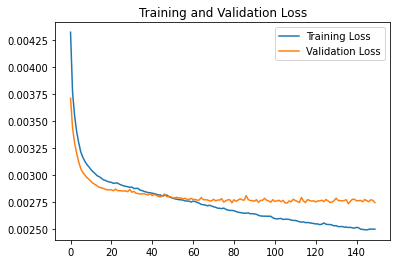

epoch: 150 Train loss: 0.0024931959332026416 time: 2.5234768390655518
epoch: 150 Eval loss: 0.0027696206234395504 time: 2.286832094192505
epoch: 151 Train loss: 0.002486555047548349 time: 2.4828031063079834
epoch: 151 Eval loss: 0.002785411197692156 time: 2.3275034427642822
epoch: 152 Train loss: 0.0024862316284696992 time: 2.61049222946167
epoch: 152 Eval loss: 0.002783433301374316 time: 2.2711260318756104
epoch: 153 Train loss: 0.0024802893634856215 time: 2.5315346717834473
epoch: 153 Eval loss: 0.0027776972856372595 time: 2.266077995300293
epoch: 154 Train loss: 0.0024847093633883688 time: 2.4537253379821777
epoch: 154 Eval loss: 0.0028031605761498213 time: 2.2095468044281006
epoch: 155 Train loss: 0.0024831007419713006 time: 2.709618330001831
epoch: 155 Eval loss: 0.0027980280574411154 time: 2.371525287628174
epoch: 156 Train loss: 0.0024790256198622736 time: 2.602898597717285
epoch: 156 Eval loss: 0.002787827979773283 time: 2.273902177810669
epoch: 157 Train loss: 0.00247575748102

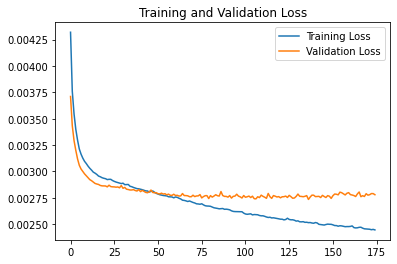

epoch: 175 Train loss: 0.0024513131364436915 time: 2.6069555282592773
epoch: 175 Eval loss: 0.0028006068896502256 time: 2.315168619155884
epoch: 176 Train loss: 0.002462763564167373 time: 2.625938892364502
epoch: 176 Eval loss: 0.0027770509477704763 time: 2.282777786254883
epoch: 177 Train loss: 0.00246252931739193 time: 2.575115919113159
epoch: 177 Eval loss: 0.0028067054226994514 time: 2.292872428894043
epoch: 178 Train loss: 0.002455817458927892 time: 2.4893407821655273
epoch: 178 Eval loss: 0.0027535962872207165 time: 2.3290834426879883
epoch: 179 Train loss: 0.0024494436469290827 time: 2.5951948165893555
epoch: 179 Eval loss: 0.0027996310964226723 time: 2.416006326675415
epoch: 180 Train loss: 0.002440686770311491 time: 2.9142961502075195
epoch: 180 Eval loss: 0.002779188333079219 time: 2.3404769897460938
epoch: 181 Train loss: 0.0024503660587918206 time: 2.6441566944122314
epoch: 181 Eval loss: 0.002792695537209511 time: 2.3430709838867188
epoch: 182 Train loss: 0.002441925300596

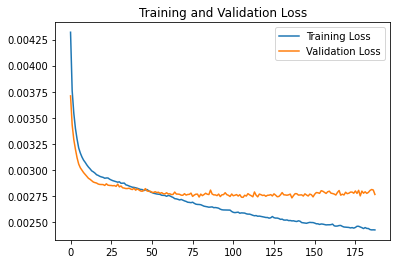

In [ ]:
av.lr=[0.005] #best Lr for this model
for lr in av.lr:
  av.LEARNING_RATE=lr
  av.lstm_bidir=False
  av.model_name="LSTM_uni_dir"
  run(fold, train_loader, val_loader, test_loader, tr_sz, test_sz, val_sz,model=OpenVaccineLSTM(av))